In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm

warnings.simplefilter('ignore')

In [2]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [3]:
# Config
READ_PICKLE_DATA = True
SAVE = False

# データ読み込み

In [4]:
if READ_PICKLE_DATA:
    train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
    test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
else:
    train = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/train_data.csv")
    test = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/test_data.csv")
    # 1列目消す
    train.drop("Unnamed: 0", axis=1, inplace=True)
    test.drop("Unnamed: 0", axis=1, inplace=True)
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

test.head()

,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,beach_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,306.701050,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,1421.016357,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,984.422791,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23
3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,29.648212,...,0.484109,0.270476,-0.320391,-0.863338,-2.708627,-10.433323,45.061952,1.546086,-14.527890,3927_11
4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,372.873108,...,0.440959,0.314171,-0.231658,-0.824787,-5.249625,2.563503,80.374689,1.827876,-6.335208,3725_01


In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    # print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
#                     df[col] = df[col].astype(np.float32)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
#         else:
#             df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
# 時間かかるしまだやらない
# train = reduce_mem_usage(train)
# test = reduce_mem_usage(test)

# データの中身確認

In [ ]:
print("trainのサイズ:", train.shape)
print("testのサイズ:", test.shape)
print("subのサイズ:", sub.shape)

trainのサイズ: (14140, 3464)
testのサイズ: (4039, 3463)
subのサイズ: (4038, 2)


In [ ]:
train.head().iloc[:, :20]

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,beach_length,coast_length,coastal_dist,cold_sst,depth,fetch,hist_cold_sst,hist_warm_sst,river_area,river_dist
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,0.000000,0.000000,5590.0,22.672894,23.664240,2590.515869,20.798887,31.061762,2986.0,126.328598
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,949.173828,949.652588,50.0,20.892162,0.000000,1534.726807,18.412085,30.809059,1920.0,36.931263
2,26.363556,127.735138,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,180.985031,521.317383,702.302429,205.0,21.143721,0.191638,766.555908,19.327492,31.236162,3694.0,1.586363
3,26.991255,127.912300,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.575,NaN,0.0,0.361444,799.384399,799.745850,150.0,20.891870,2.553752,1542.904297,18.409414,30.816591,1920.0,36.497868
4,26.988255,127.917252,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.225,NaN,0.0,6.062498,954.537292,960.599792,210.0,20.883181,9.874817,1354.861572,18.379198,30.824339,1920.0,35.928719


In [ ]:
train.head().iloc[:, :20]

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,beach_length,coast_length,coastal_dist,cold_sst,depth,fetch,hist_cold_sst,hist_warm_sst,river_area,river_dist
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,0.000000,0.000000,5590.0,22.672894,23.664240,2590.515869,20.798887,31.061762,2986.0,126.328598
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,949.173828,949.652588,50.0,20.892162,0.000000,1534.726807,18.412085,30.809059,1920.0,36.931263
2,26.363556,127.735138,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,180.985031,521.317383,702.302429,205.0,21.143721,0.191638,766.555908,19.327492,31.236162,3694.0,1.586363
3,26.991255,127.912300,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.575,NaN,0.0,0.361444,799.384399,799.745850,150.0,20.891870,2.553752,1542.904297,18.409414,30.816591,1920.0,36.497868
4,26.988255,127.917252,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.225,NaN,0.0,6.062498,954.537292,960.599792,210.0,20.883181,9.874817,1354.861572,18.379198,30.824339,1920.0,35.928719


In [ ]:
train.head().iloc[:, 20:40]

,Salinity_annual,warm_sst,sst_annual,sst_ymd,sst_diff,Blue,Green,Red,NIR,SWIR1,TIRS1,TIRS2,SWIR2,MSAVI,EVI,NBR,NBR2,NDMI,NDVI,NDWI
0,34.560532,29.149746,25.886436,28.750601,-2.864164,44.513775,24.466267,12.291277,4.496400,0.274631,8.243456,8.218559,0.126413,-1.371784,0.076538,0.945309,0.369581,0.884876,-0.464321,0.689504
1,34.657925,28.947212,24.752907,27.285749,-2.532844,76.809082,72.848259,50.989620,70.342323,6.375916,8.649507,8.658948,1.017969,0.273709,-0.243384,0.971470,0.724646,0.833784,0.159502,0.017501
2,34.709606,29.123978,24.983583,26.944033,-1.960448,51.095936,34.678707,18.480610,7.821566,0.640860,8.279950,8.255633,0.114172,-1.195080,0.101124,0.971226,0.697570,0.848540,-0.405253,0.631929
3,34.658588,28.945391,24.756948,21.462372,3.294577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34.658199,28.924425,24.729166,21.429968,3.299199,58.162979,30.404083,9.919600,4.474403,0.213160,8.385872,8.375682,0.036060,-0.995109,0.036670,0.984011,0.710619,0.909053,-0.378296,0.743429


In [ ]:
# センチネル
train.head().iloc[:, 100:120]

,MAX_B12,MAX_B8A,MAX_BB1,MAX_Bcc,MAX_BGI,MAX_BNDVI,MAX_BOA,MAX_BRI,MAX_BWDRVI,MAX_CARI,MAX_Chlgreen,MAX_Chlred_edge,MAX_CI,MAX_CIgreen,MAX_CIrededge,MAX_CLD,MAX_CRred,MAX_CSI,MAX_CVI,MAX_D678_500
0,283.159546,291.144745,0.027413,0.522806,1.734970,-0.356630,1049.157715,-510.555206,-0.907725,0.073530,12.869112,1.425079,0.004414,-0.375355,0.044957,0.000000,0.726402,1.226063,0.351828,-0.027583
1,999.331177,2687.234863,0.165047,0.330363,0.792061,0.641044,1391.050415,25.036474,-0.368204,0.656143,2.180593,1.826380,-0.048293,1.553124,0.362895,25.433641,1.000000,7.344153,1.847861,0.018330
2,1216.951416,1487.556519,0.167792,0.338243,0.881195,0.164533,1716.809082,9.661550,-0.754226,0.368939,1.539484,1.326136,4.169011,0.103096,-0.067936,26.501945,0.993842,2.566120,0.892214,0.002320
3,1167.143555,1164.452148,0.107899,0.445233,1.020586,-0.104544,1398.978760,-13.672744,-0.849585,0.268316,3.430868,1.686033,1.480026,-0.195466,-0.023570,6.377331,0.844212,1.185939,0.583780,-0.037810
4,932.239197,914.033997,0.083589,0.553837,1.214157,-0.355714,1722.546509,-63.169350,-0.906062,0.208666,5.729465,1.229421,-0.002413,-0.384653,-0.019891,2.605357,0.726092,1.165526,0.363947,-0.093400


In [ ]:
# ランドサット(2000)
train.head().iloc[:, 320:340]

,MAX_TIRS2_2000,MAX_TSAVI_2000,MAX_Alteration_2000,MAX_AVI_2000,MAX_BWDRVI_2000,MAX_Chlgreen_2000,MAX_Cigreen_2000,MAX_Cirededge_2000,MAX_Chlred_edge_2000,MAX_CVI_2000,MAX_CI_2000,MAX_CTVI_2000,MAX_CRI550_2000,MAX_D678_500_2000,MAX_DVIMSS_2000,MAX_DSWI_2000,MAX_DSWI_5_2000,MAX_EVI_2000,MAX_Fe3_2000,MAX_Ferric_Oxides_2000
0,8.704915,-0.464263,3.856866,-12.126781,-0.94920,7.108872,-0.607460,-0.427343,3.041875,0.269075,-1.197285,0.559811,-0.006776,-31.190393,12.727030,2.594336,-0.803778,0.108160,0.685472,0.179049
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8.517535,-0.867842,3.740300,-19.701977,-0.98672,9.965029,-0.899649,-0.731078,3.718557,0.037447,-3.023228,0.208581,-0.009247,-40.736786,-4.777935,2.864991,-2.342422,0.076694,0.373161,0.108690
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ランドサット(2001)
train.head().iloc[:, 480:500]

,MAX_CI_2001,MAX_CTVI_2001,MAX_CRI550_2001,MAX_D678_500_2001,MAX_DVIMSS_2001,MAX_DSWI_2001,MAX_DSWI_5_2001,MAX_EVI_2001,MAX_Fe3_2001,MAX_Ferric_Oxides_2001,MAX_Ferrous_Silicates_2001,MAX_GEMI_2001,MAX_GVMI_2001,MAX_Gossan_2001,MAX_GARI_2001,MAX_GLI_2001,MAX_H_2001,MAX_IR550_2001,MAX_mCRIG_2001,MAX_mCRIRE_2001
0,-2.720967,0.388873,-0.017246,-33.775261,0.149484,2.413544,-1.597001,0.067544,0.482824,0.077907,0.457720,-55.584461,0.925409,0.032852,-0.245171,-0.065288,1.539167,0.038897,-0.090273,-0.308358
1,-1.826635,0.493584,-0.013895,-31.300365,2.588356,2.081686,-1.161146,0.088733,0.591882,0.087587,0.395691,-85.194260,0.929300,0.042007,-0.203096,-0.062115,1.534507,0.034541,-0.114196,-0.309931
2,-1.392556,0.484843,-0.005399,-37.198326,11.469422,2.228262,-1.071308,0.112148,0.581118,0.121323,0.261981,-174.542313,0.955801,0.069737,-0.050014,0.017999,1.547276,0.023813,-0.057496,-0.239527
3,-2.573951,0.413605,-0.017737,-32.676224,0.794617,2.307033,-1.463942,0.068684,0.504970,0.113597,0.256293,-54.079197,0.937795,0.050295,-0.252068,-0.071863,1.537397,0.039777,-0.099692,-0.318865
4,-3.470154,0.323599,-0.022430,-32.441597,-0.115888,2.644059,-1.843691,0.054475,0.433400,0.068729,0.314674,-32.936260,0.949040,0.028282,-0.293389,-0.084829,1.537036,0.046359,-0.086290,-0.319446


In [ ]:
# ランドサット(2020)
train.head().iloc[:, -20:]

,MIN_GARI_2020,MIN_GLI_2020,MIN_H_2020,MIN_IR550_2020,MIN_mCRIG_2020,MIN_mCRIRE_2020,MIN_MVI_2020,MIN_MCARI1_2020,MIN_MCARI2_2020,MIN_NLI_2020,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,-0.227912,-0.058645,1.545303,0.016962,-0.104280,-0.296901,5.140503,8.142066,0.258932,0.380021,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,-2.097901,0.042011,0.851407,0.014977,-0.093516,-0.580301,9.890694,0.821317,0.072868,0.292921,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,-0.091362,0.019369,1.535878,0.020327,-0.046731,-0.225474,7.512408,9.029748,0.749036,0.020995,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22
3,-0.191027,-0.000946,1.548308,0.017960,-0.053313,-0.316224,5.676642,21.863384,2.481940,0.182806,0.647862,0.240924,-0.244501,-0.860716,-2.373051,2.988302,51.879647,6.054869,-5.697032,4027_13
4,-0.298366,-0.062281,1.559467,0.018316,-0.068322,-0.369991,6.036971,27.179392,2.926882,0.256902,0.664400,0.215578,-0.320408,-0.882317,-2.095053,2.436510,50.467718,8.537779,-1.617806,4027_13


# pickle形式で保存

In [ ]:
if SAVE:
    train.to_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
    test.to_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")

# 可視化

## データの時期の分布

In [ ]:
train_date = train[["year", "month"]]
test_date = test[["year", "month"]]

def convert_int_into_str(x):
    x_str = str(int(x))
    if len(x_str)==1:
        return "0" + x_str
    return x_str

train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
test_date["month_str"] = test_date["month"].apply(convert_int_into_str)

train_date["date"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
test_date["date"] = (test_date["year"].astype(int).astype(str) + test_date["month_str"]).astype(int)
train_date.sort_values(by="date", inplace=True)
test_date.sort_values(by="date", inplace=True)
train_date["label"] = "train"
test_date["label"] = "test"

train_test_date = pd.concat((train_date, test_date))

train_test_date

,year,month,month_str,date,label
4299,1999.0,11.0,11,199911,train
1921,1999.0,11.0,11,199911,train
11653,1999.0,11.0,11,199911,train
6871,1999.0,11.0,11,199911,train
11623,1999.0,11.0,11,199911,train
...,...,...,...,...,...
2086,2019.0,10.0,10,201910,test
2085,2019.0,10.0,10,201910,test
2081,2019.0,10.0,10,201910,test
2072,2019.0,10.0,10,201910,test


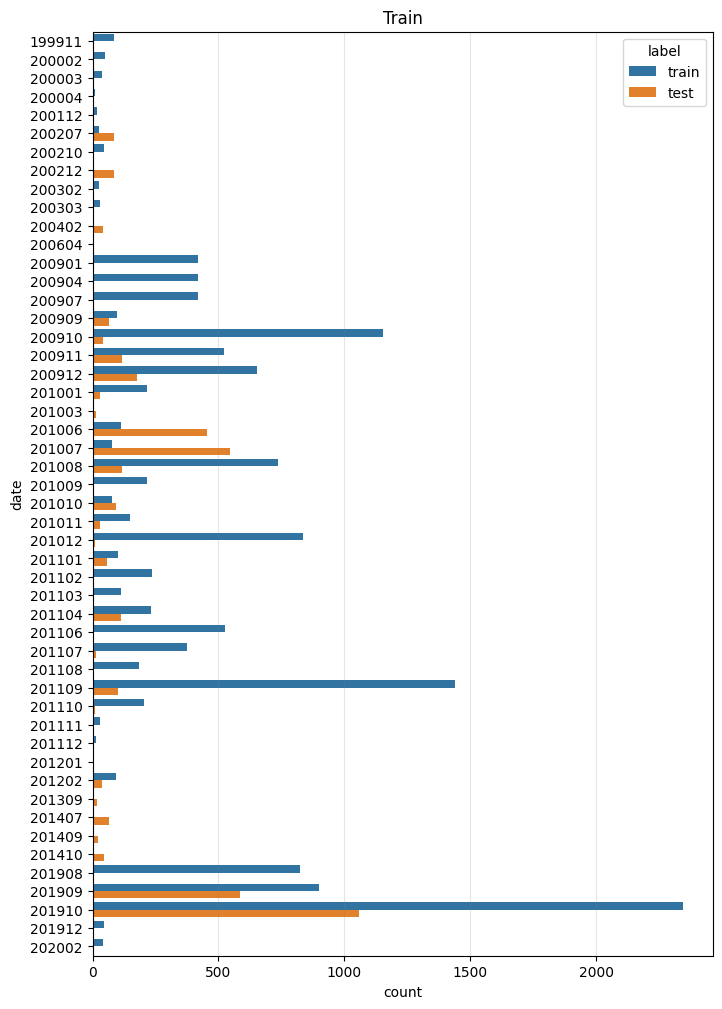

In [ ]:
fig = plt.figure(figsize=(8, 12))
ax1 = fig.add_subplot()
ax1.grid(color="gray", alpha=0.2)
ax1.set_title("Train")
sns.countplot(y="date", data=train_test_date, hue="label", ax=ax1);

# ax2 = fig.add_subplot(122)
# ax2.grid(color="gray", alpha=0.2)
# ax2.set_title("Train")
# sns.countplot(y="date", data=test_date, ax=ax2);

## データの時期ごとのcoverの分布

In [ ]:
train_date2 = train[["year", "month", "cover"]]

train_date2["month_str"] = train_date2["month"].apply(convert_int_into_str)

train_date2["date"] = (train_date2["year"].astype(int).astype(str) + train_date2["month_str"]).astype(int)
train_date2.sort_values(by="date", inplace=True)
train_date2.head()

,year,month,cover,month_str,date
4299,1999.0,11.0,0.1500,11,199911
1921,1999.0,11.0,0.0300,11,199911
11653,1999.0,11.0,0.0050,11,199911
6871,1999.0,11.0,0.0175,11,199911
11623,1999.0,11.0,0.0050,11,199911


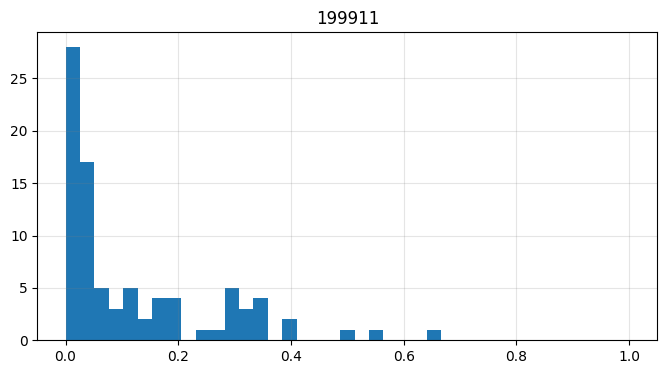

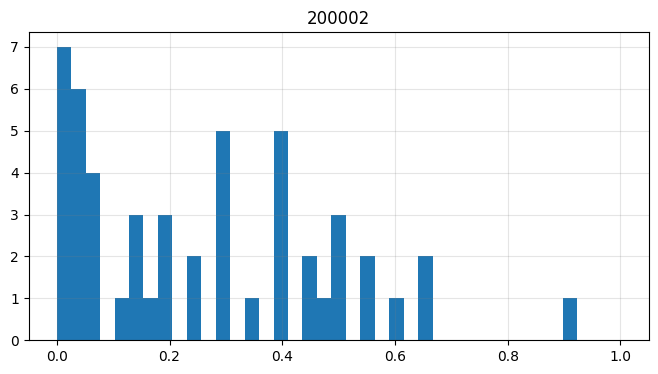

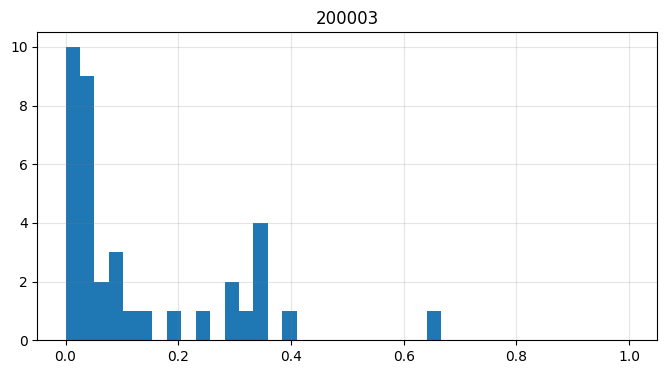

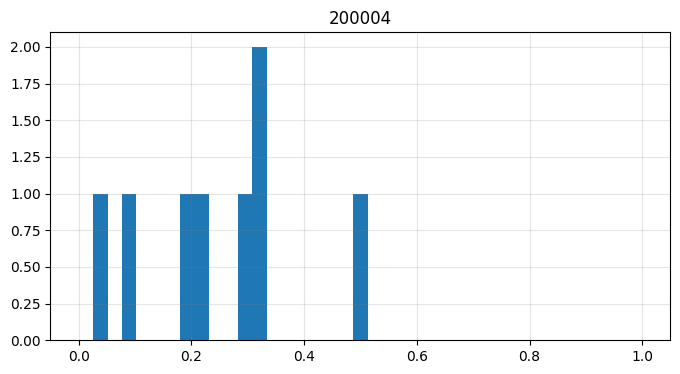

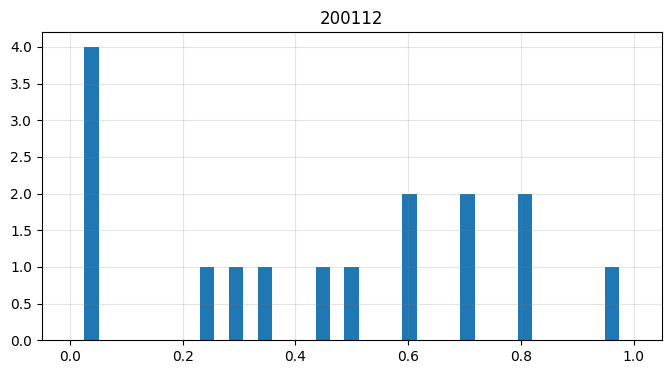

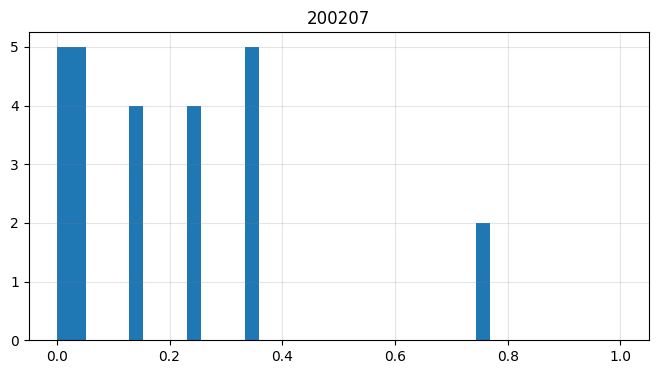

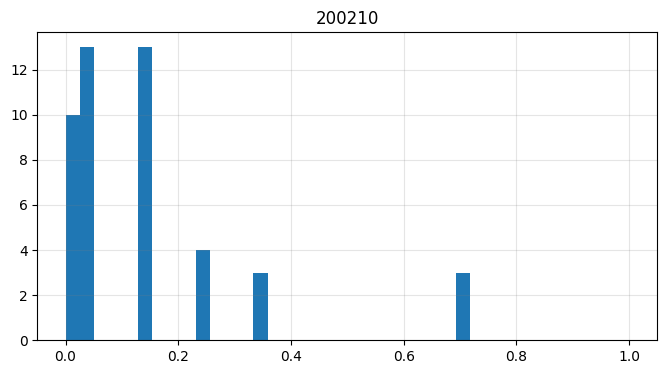

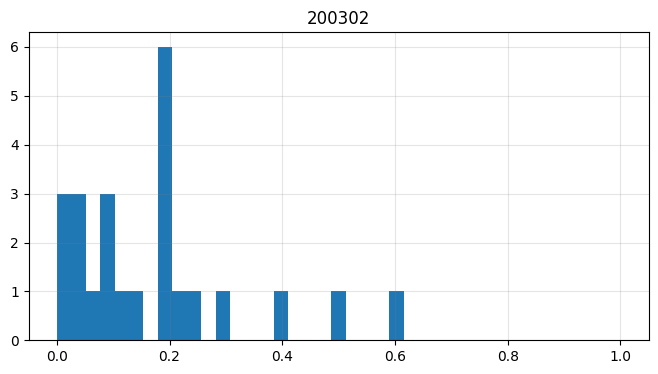

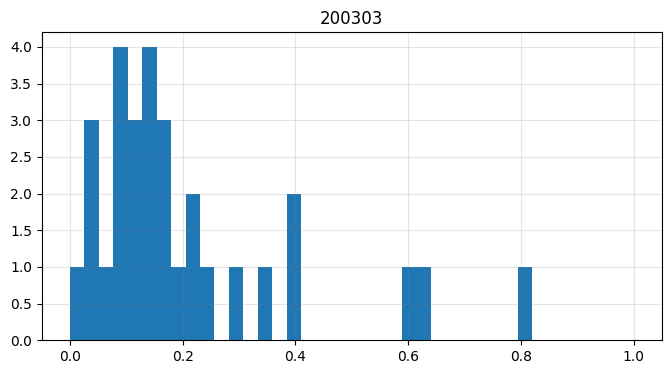

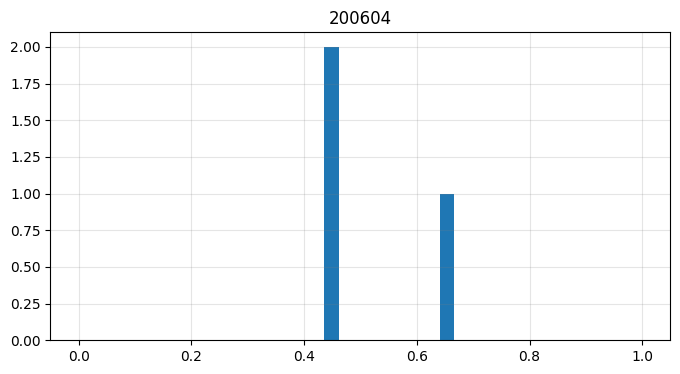

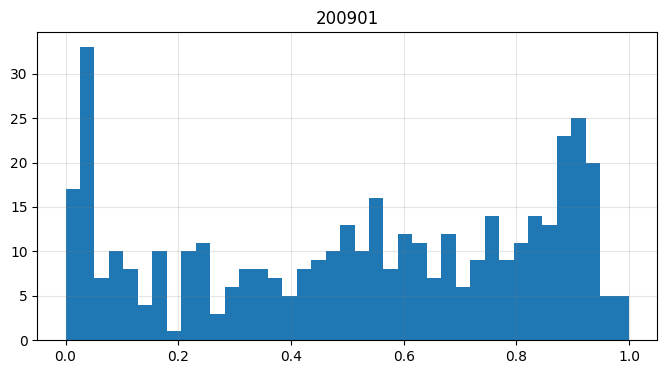

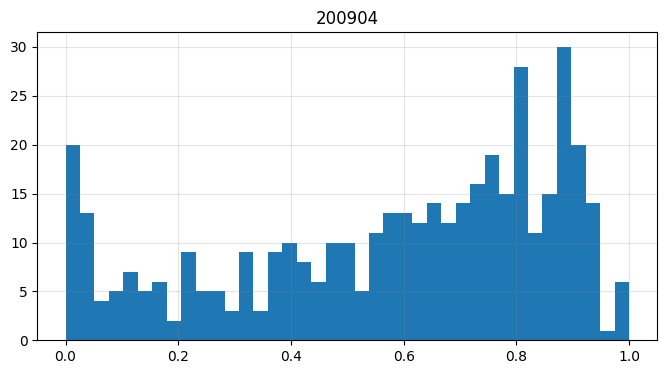

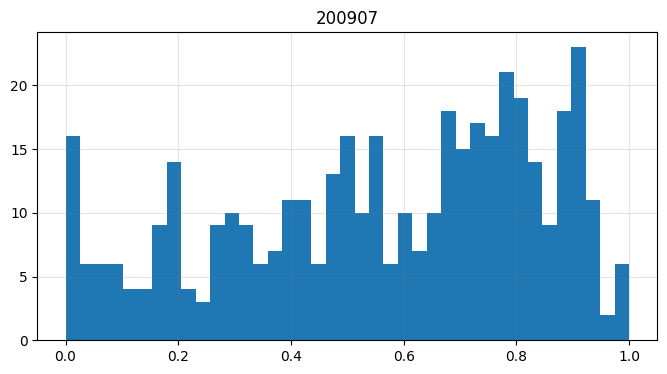

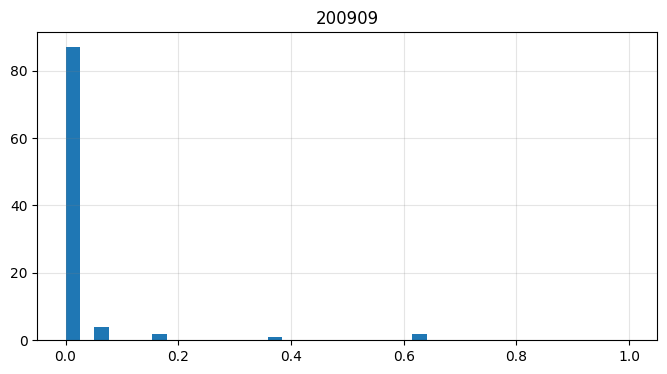

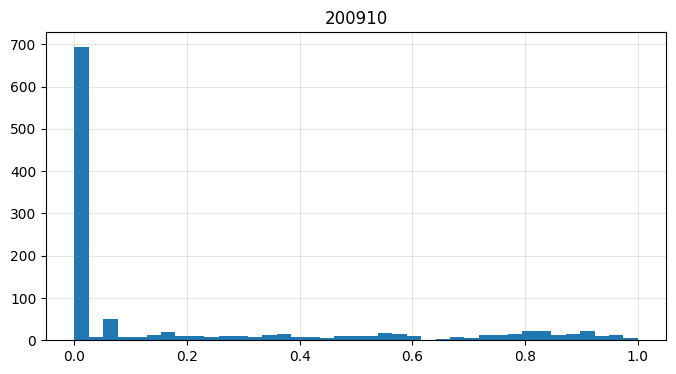

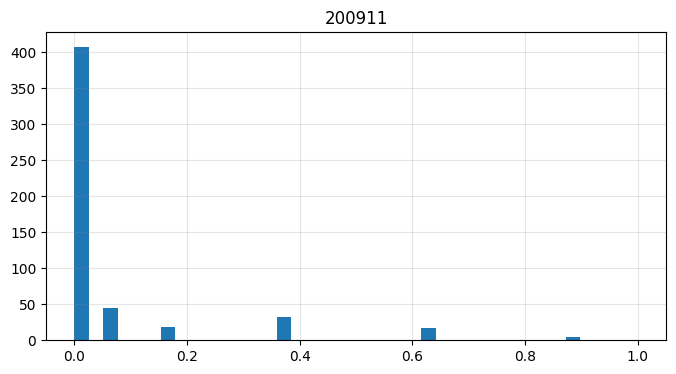

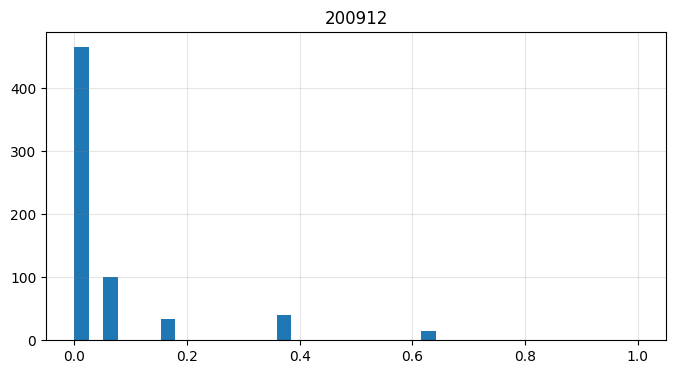

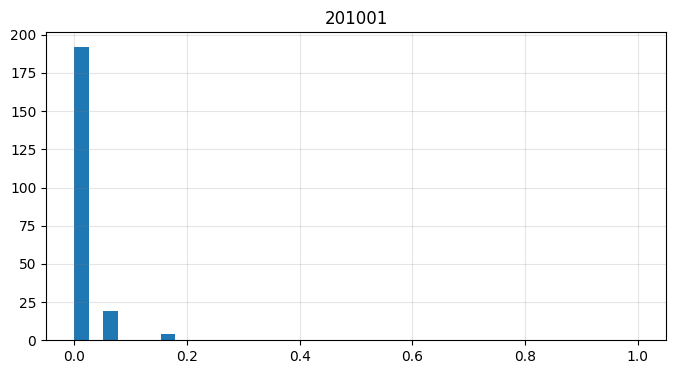

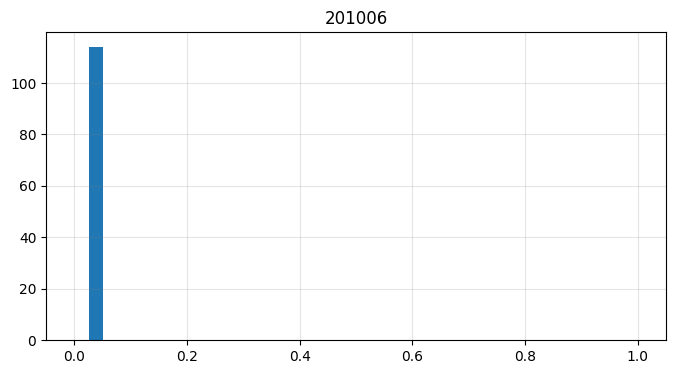

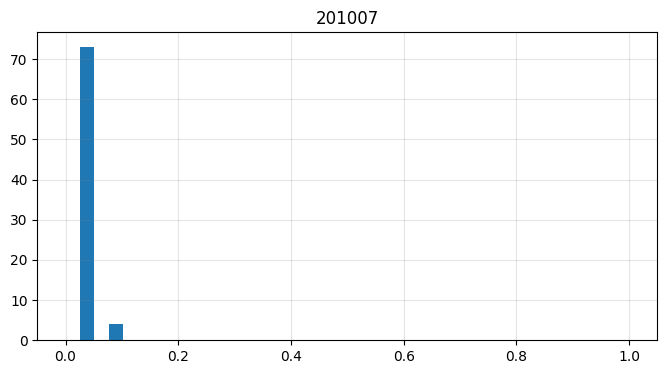

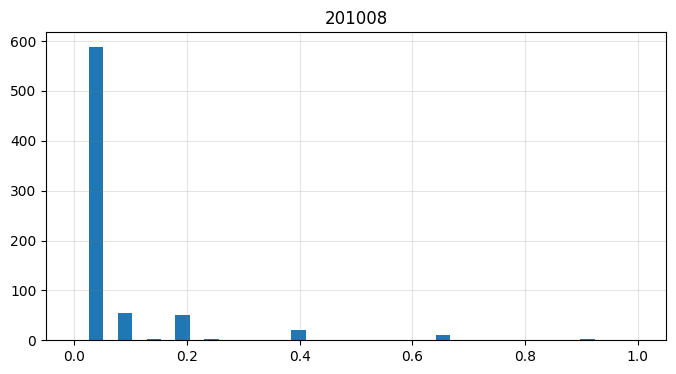

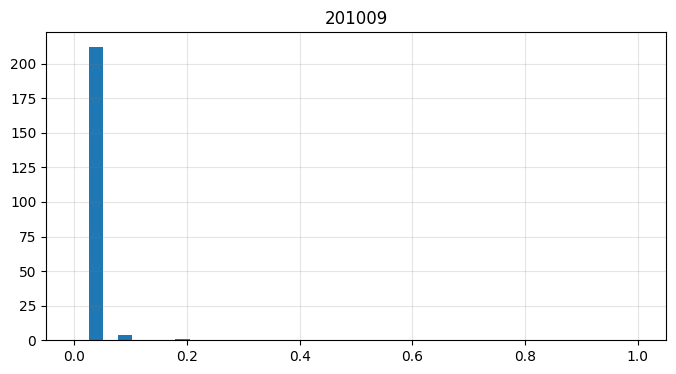

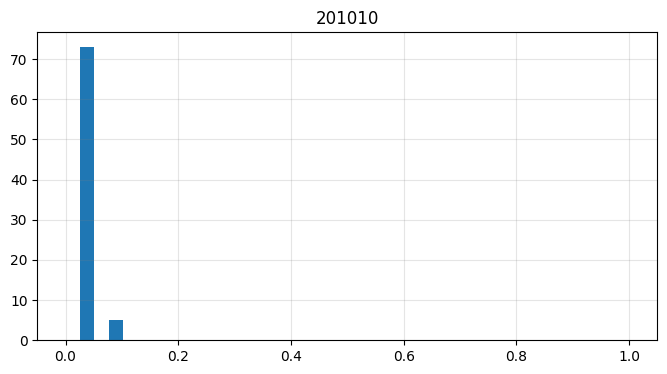

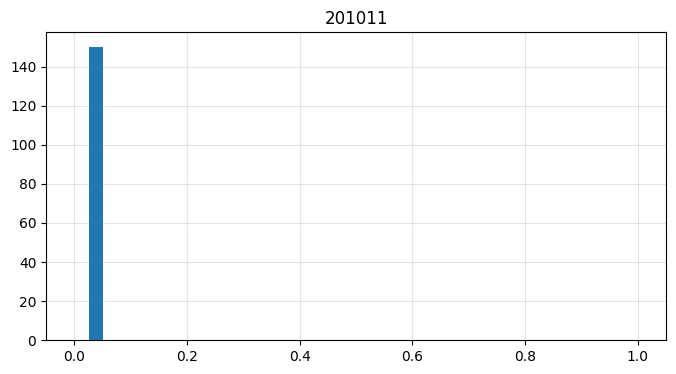

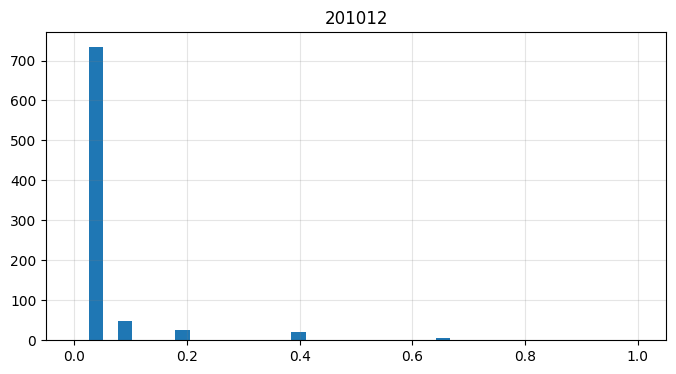

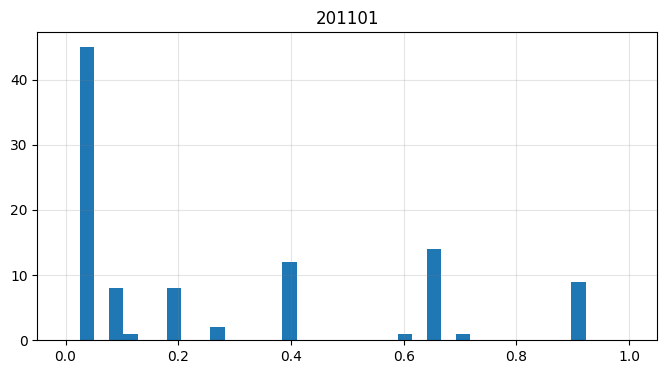

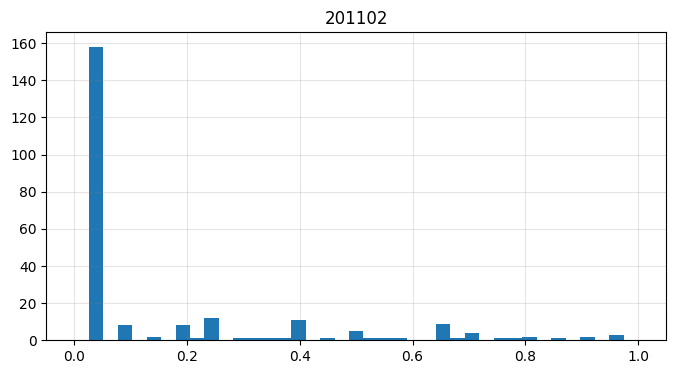

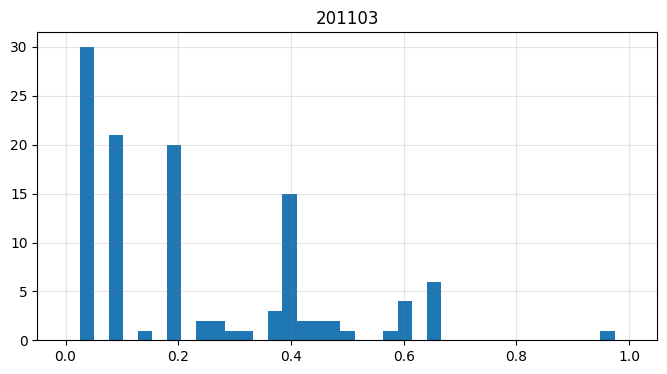

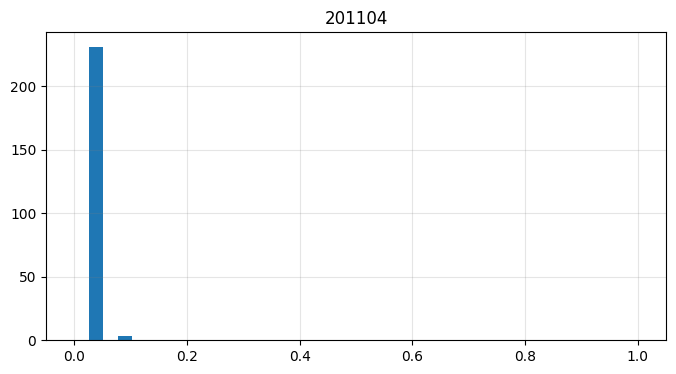

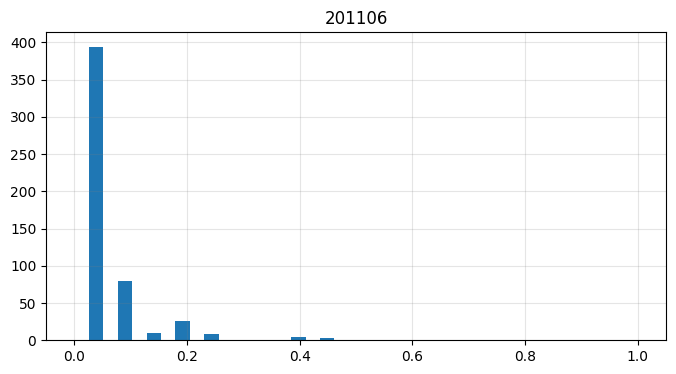

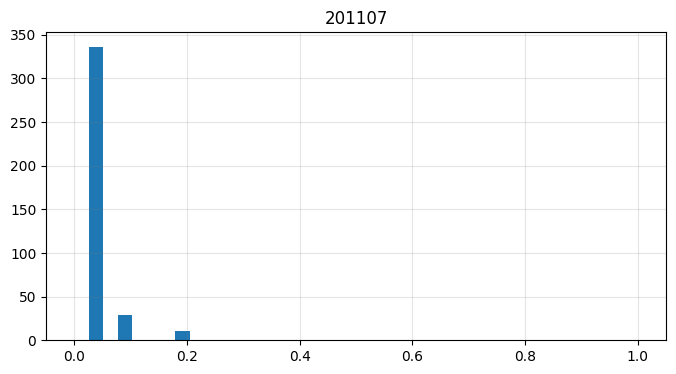

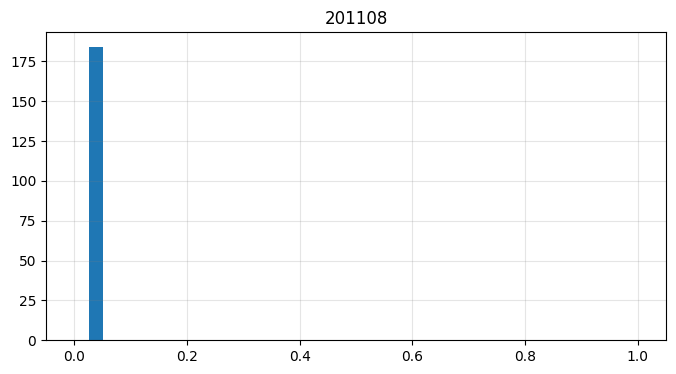

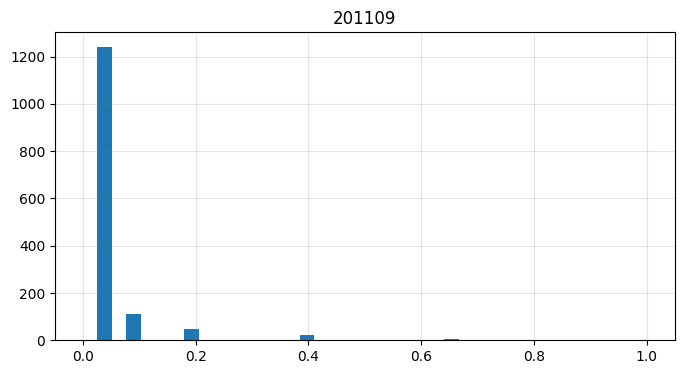

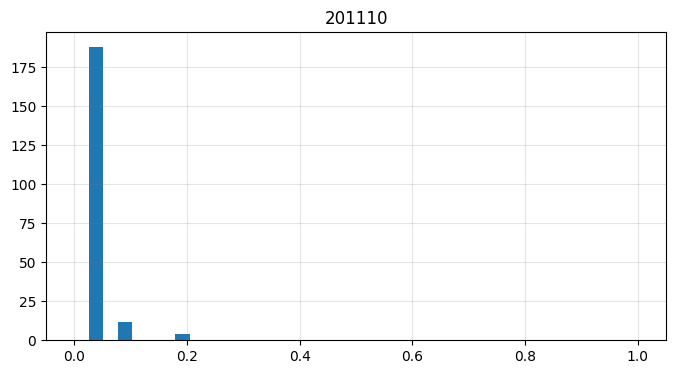

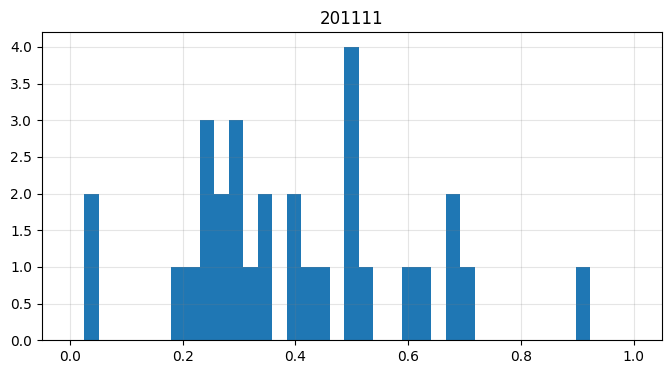

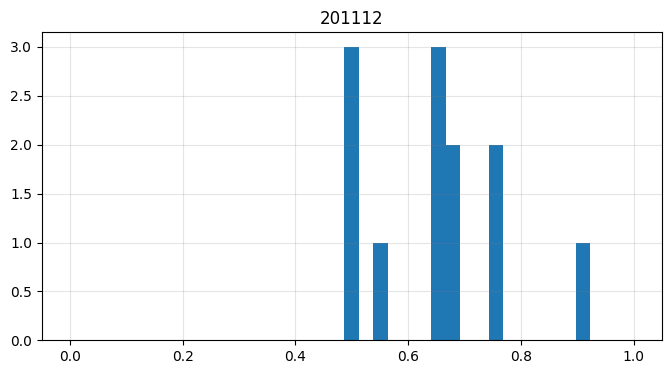

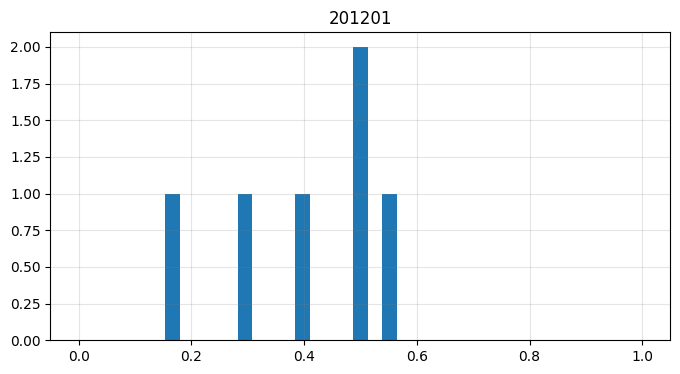

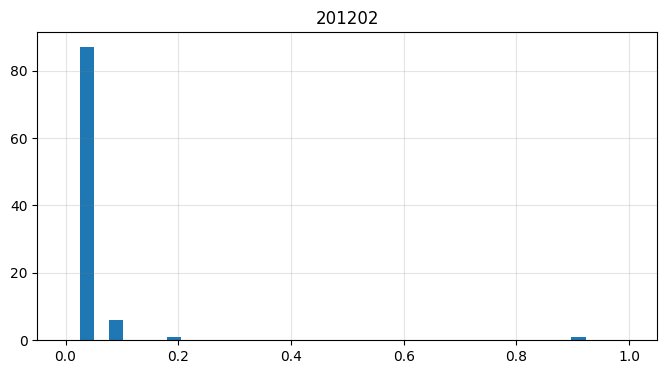

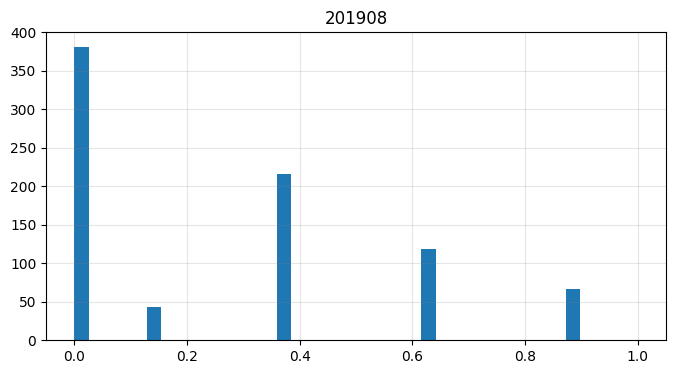

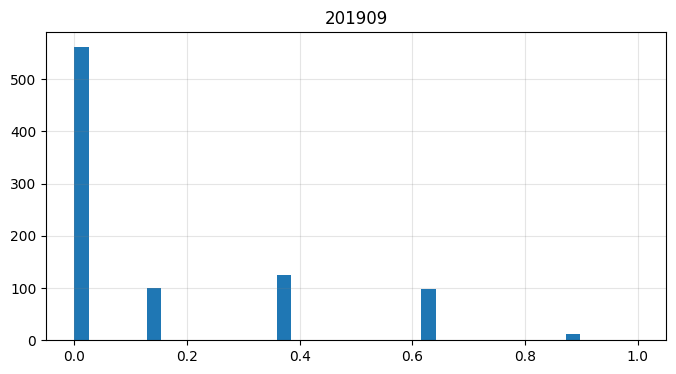

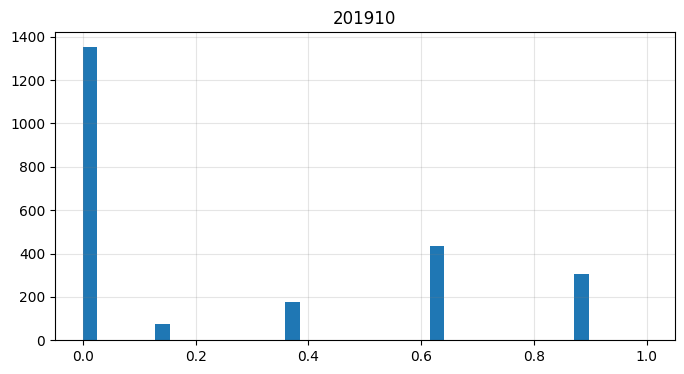

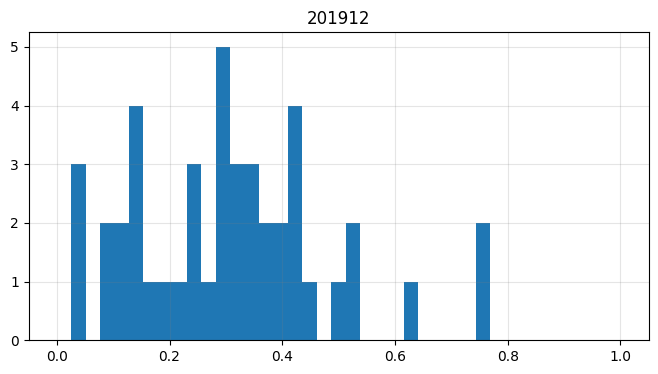

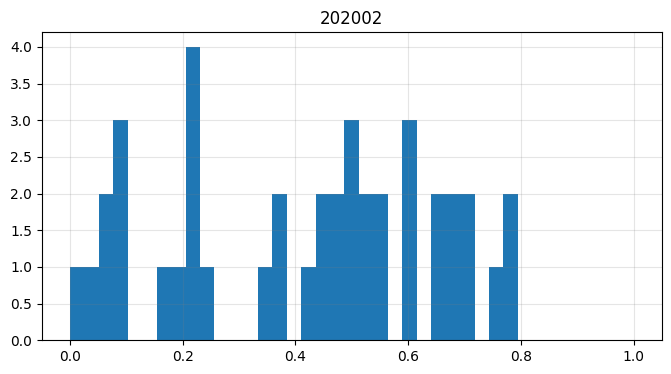

In [ ]:
date_list = sorted(train_date2["date"].unique())
bins = np.linspace(0, 1, 40)
for date in date_list:
    tmp = train_date2[train_date2["date"]==date].copy()
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.grid(alpha=0.2, color="gray")
    ax.hist(tmp["cover"], bins=bins)
    ax.set_title(date)
    plt.show()

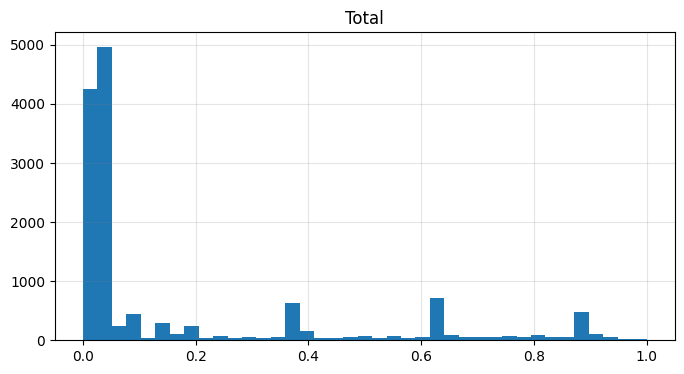

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.grid(alpha=0.2, color="gray")
ax.hist(train_date2["cover"], bins=bins)
ax.set_title("Total")
plt.show()

In [ ]:
print(f"coverの平均値: {train['cover'].mean():.4f}")
print(f"coverの中央値: {train['cover'].median()}")

coverの平均値: 0.1832
coverの中央値: 0.05000000074505806


## 主要なデータの分布

In [ ]:
def make_violinplot(colname):
    train_tmp = train[[colname]].dropna()
    train_tmp["label"] = "train"
    test_tmp = test[[colname]].dropna()
    test_tmp["label"] = "test"
    tmp = pd.concat((train_tmp, test_tmp))
    fig, ax = plt.subplots(figsize=(8, 12))
    ax.grid(color="gray", alpha=0.2)
    ax.set_title(colname)
    sns.violinplot(x="label", y=colname, data=tmp, ax=ax);

In [ ]:
cols_vis = [
    "lat",
    "lon",
    "area",
    "depth_original",
    "depth",
    "cliff_length",
    "aicial_length",
    "beach_length",
    "coast_length",
    "coastal_dist",
    "fetch",
    "cold_sst",
    "hist_cold_sst",
    "warm_sst",
    "hist_warm_sst",
    "sst_annual",
    "sst_ymd",
    "sst_diff",
    "river_area",
    "river_dist",
    "Salinity_annual",
]

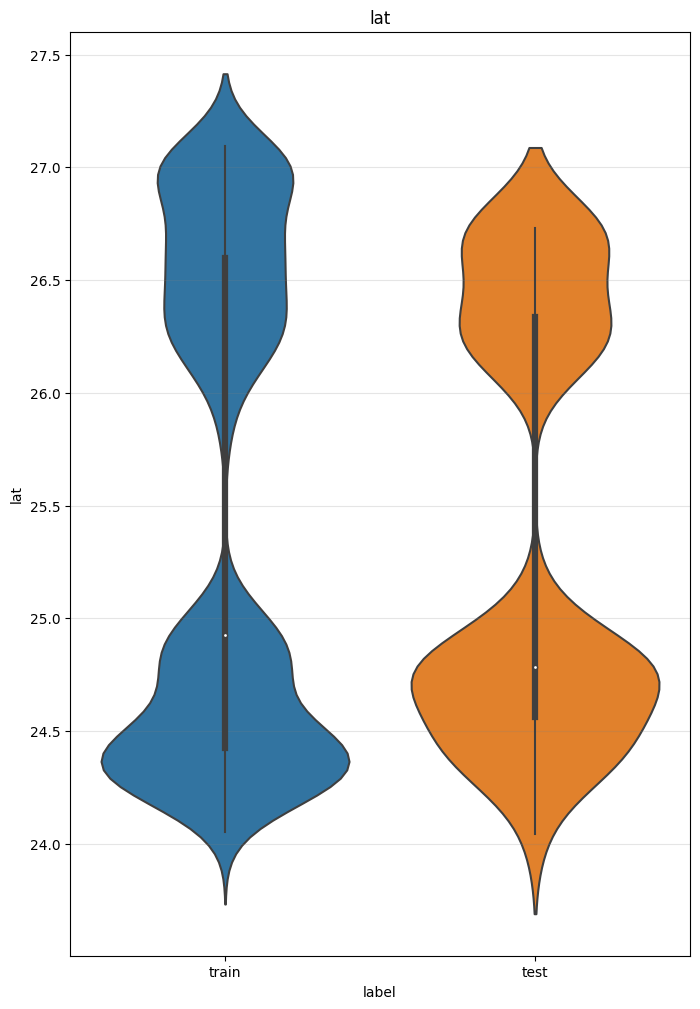

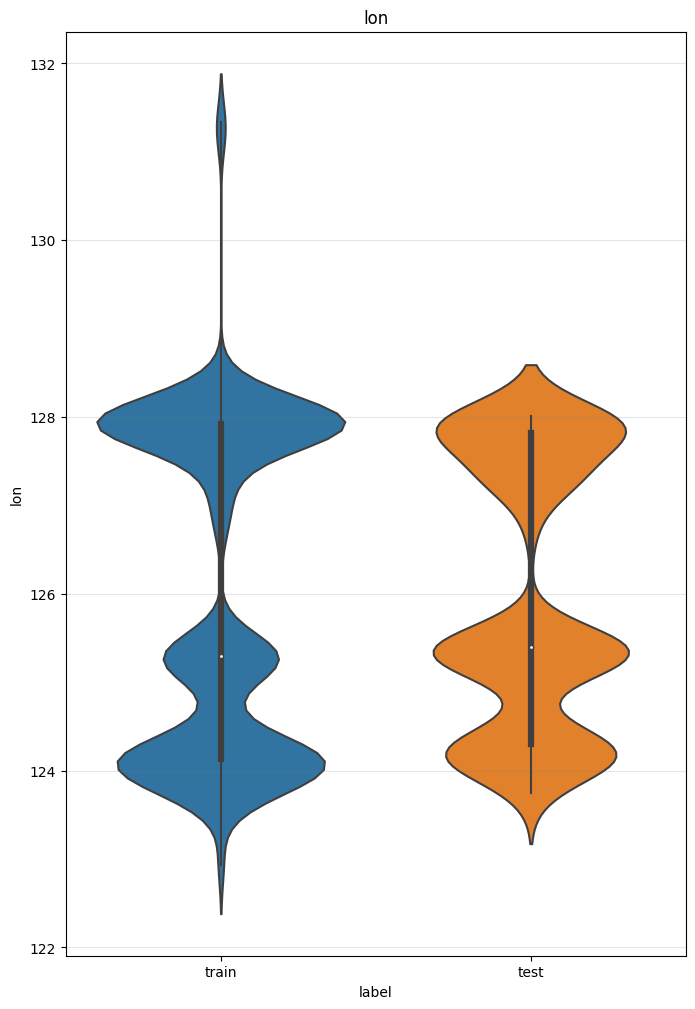

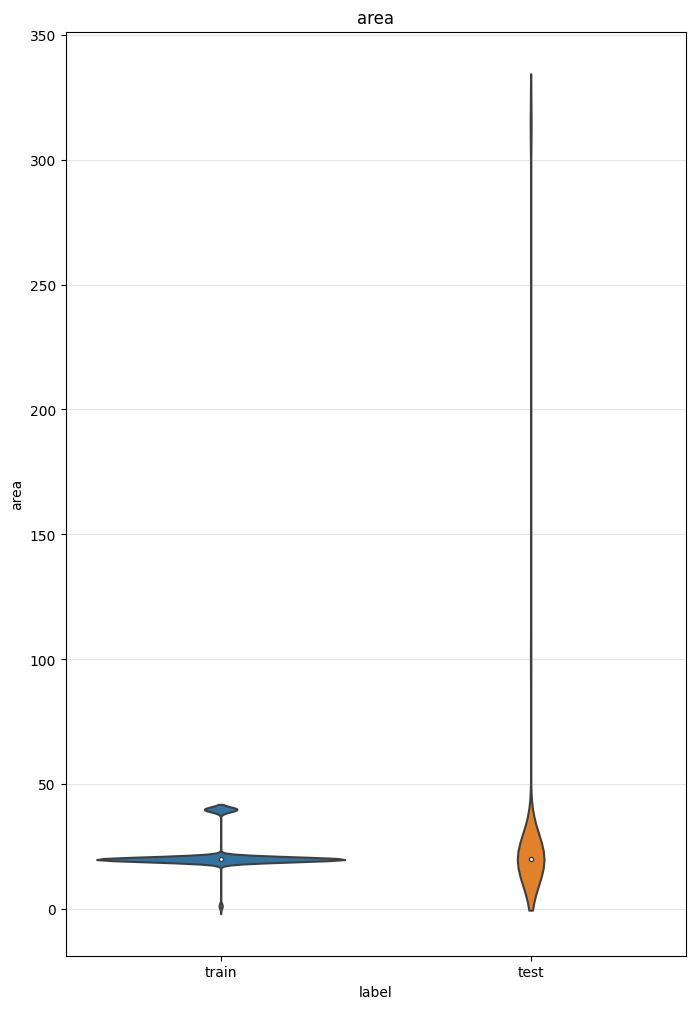

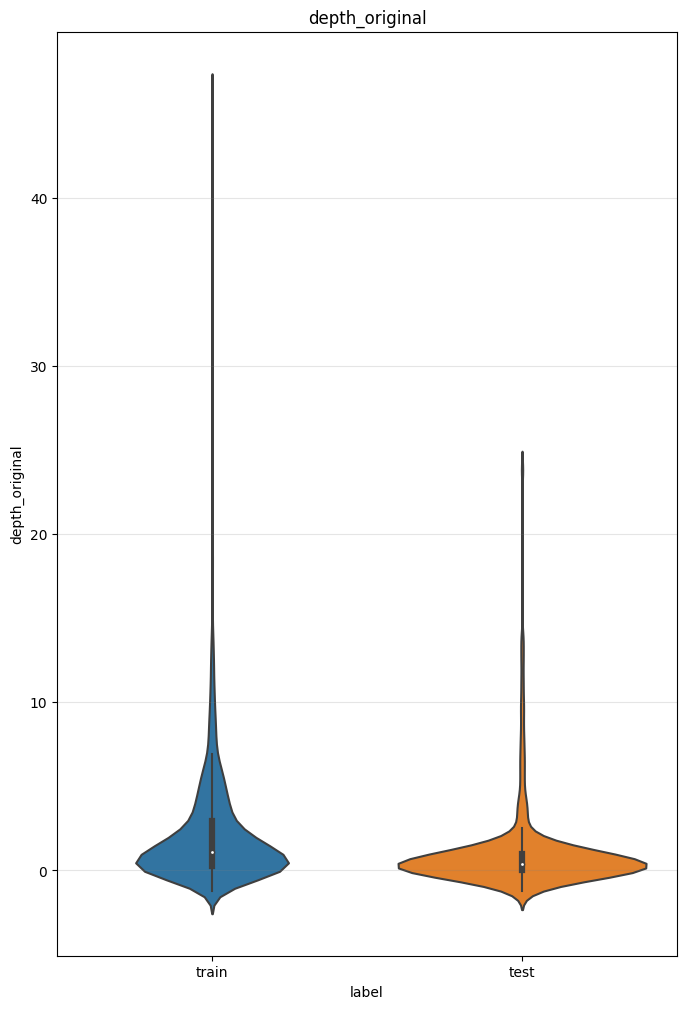

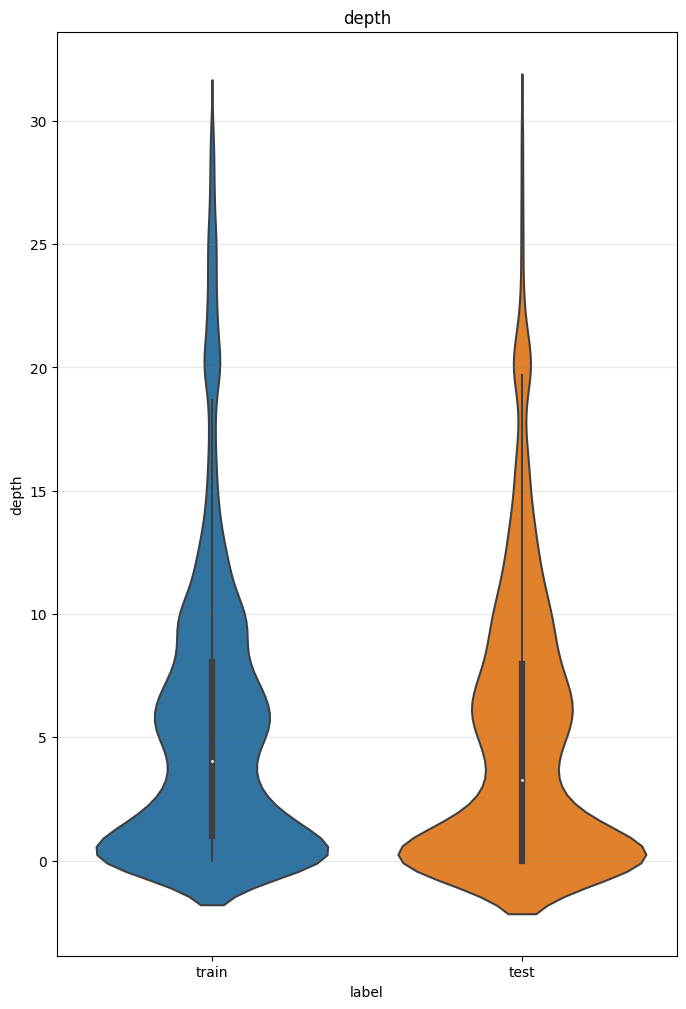

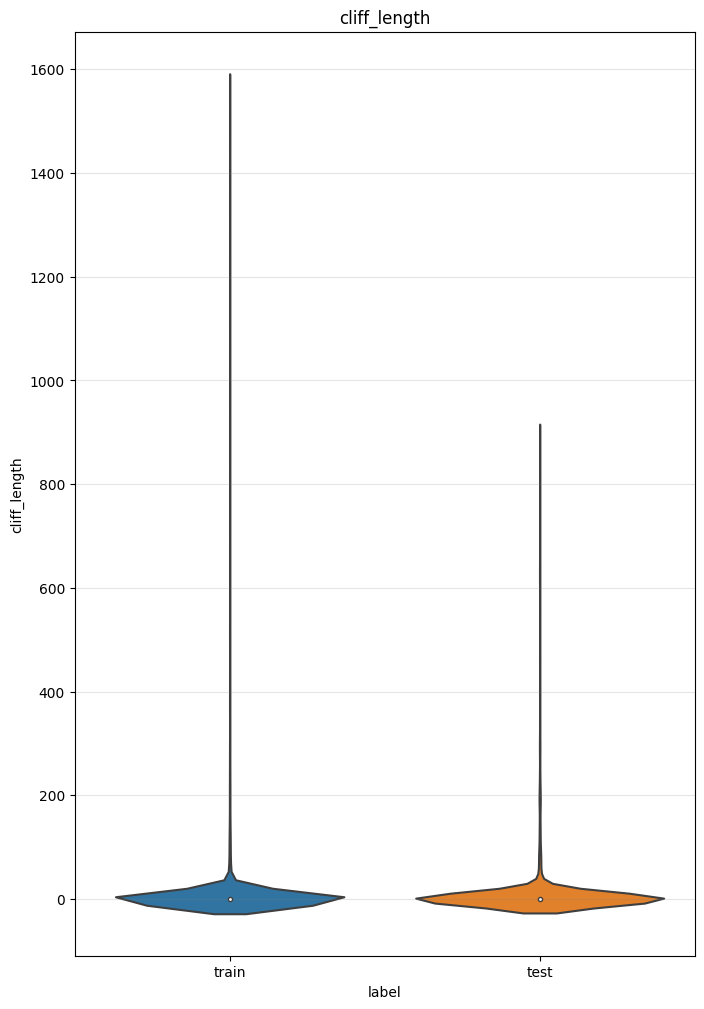

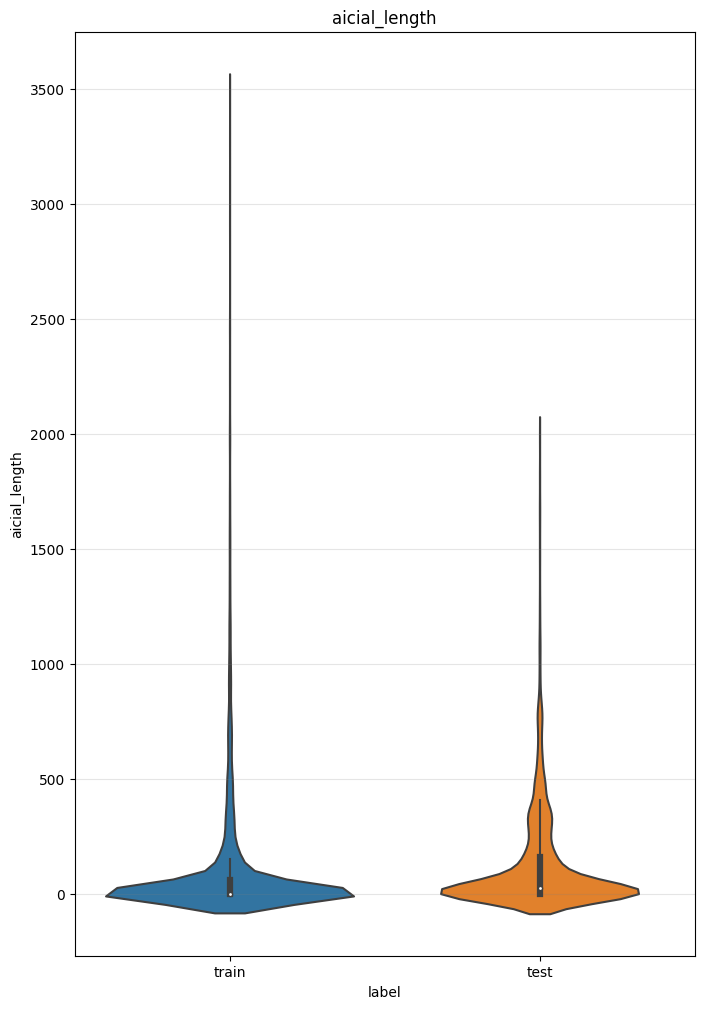

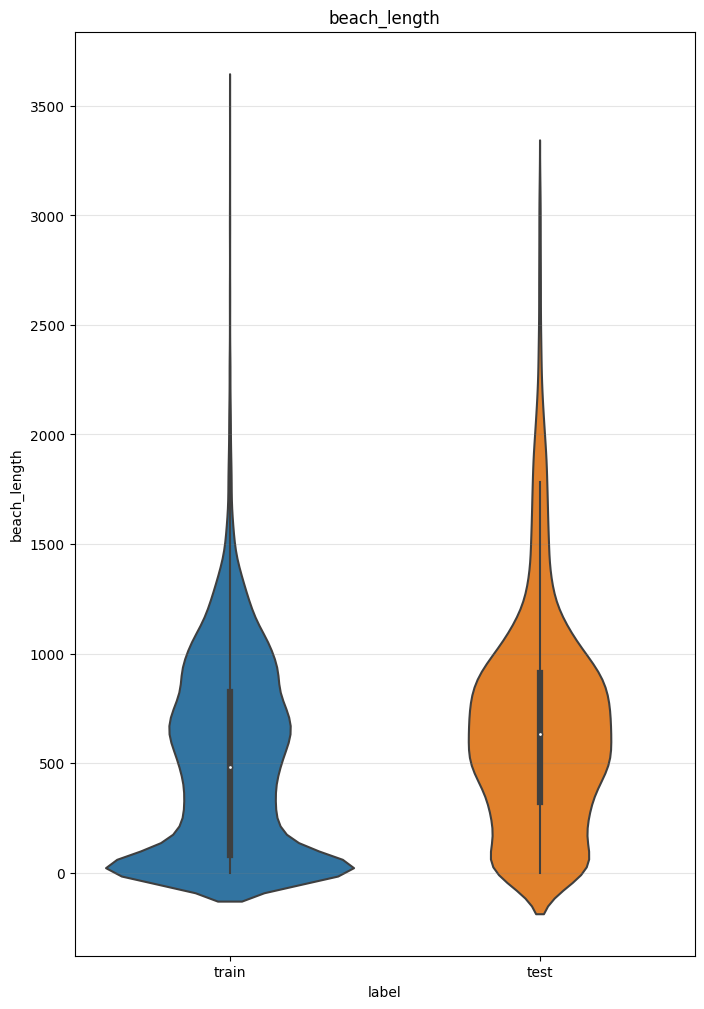

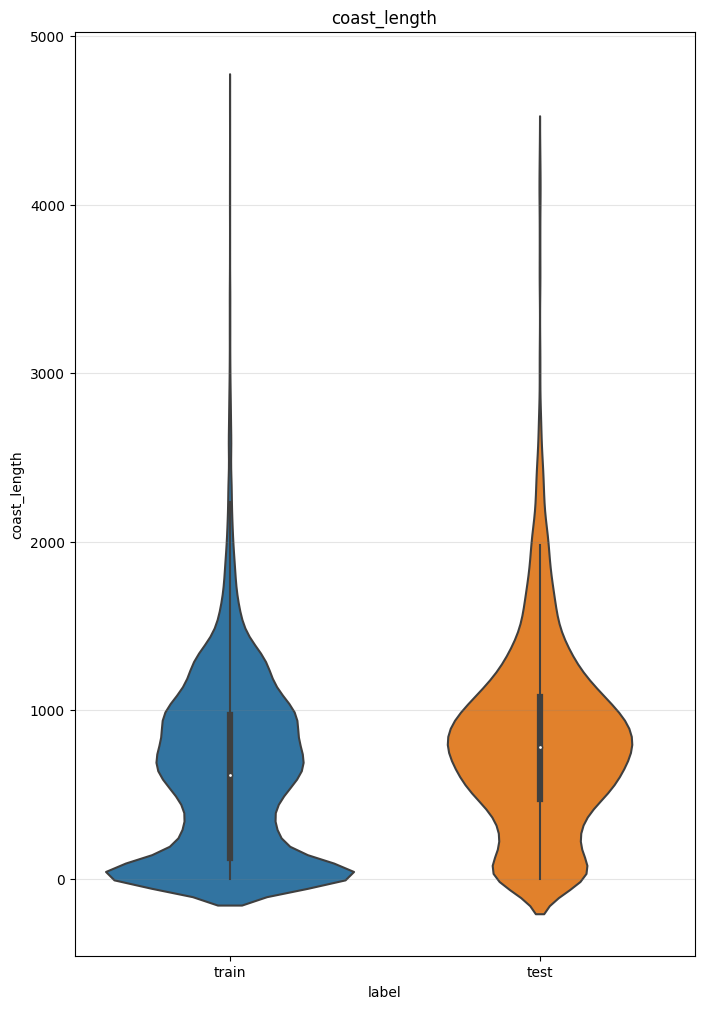

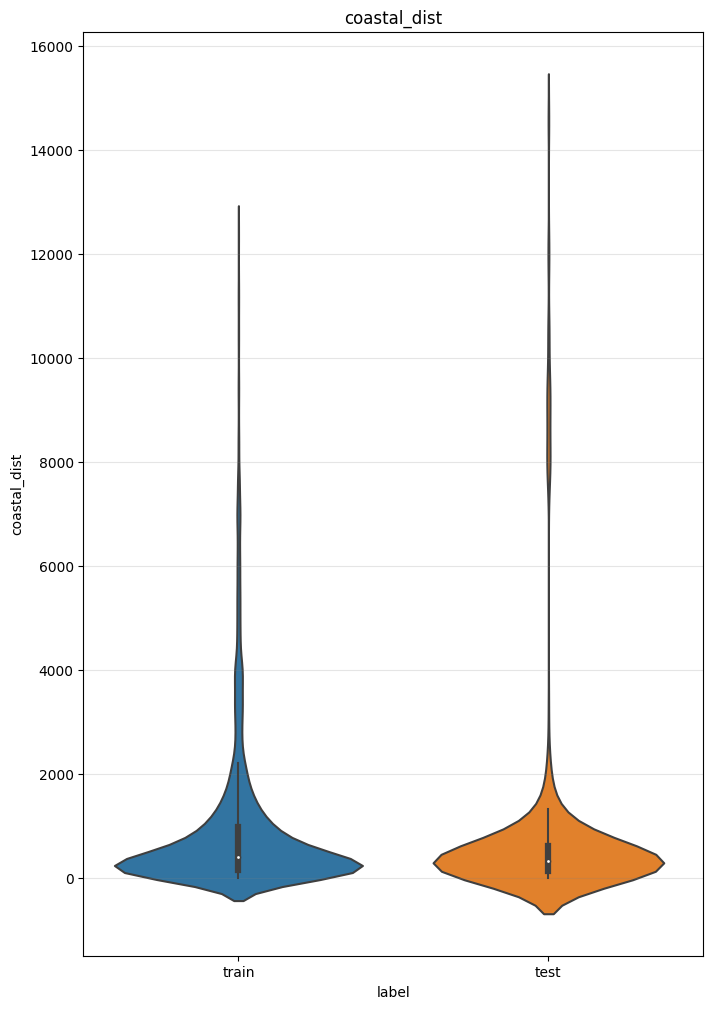

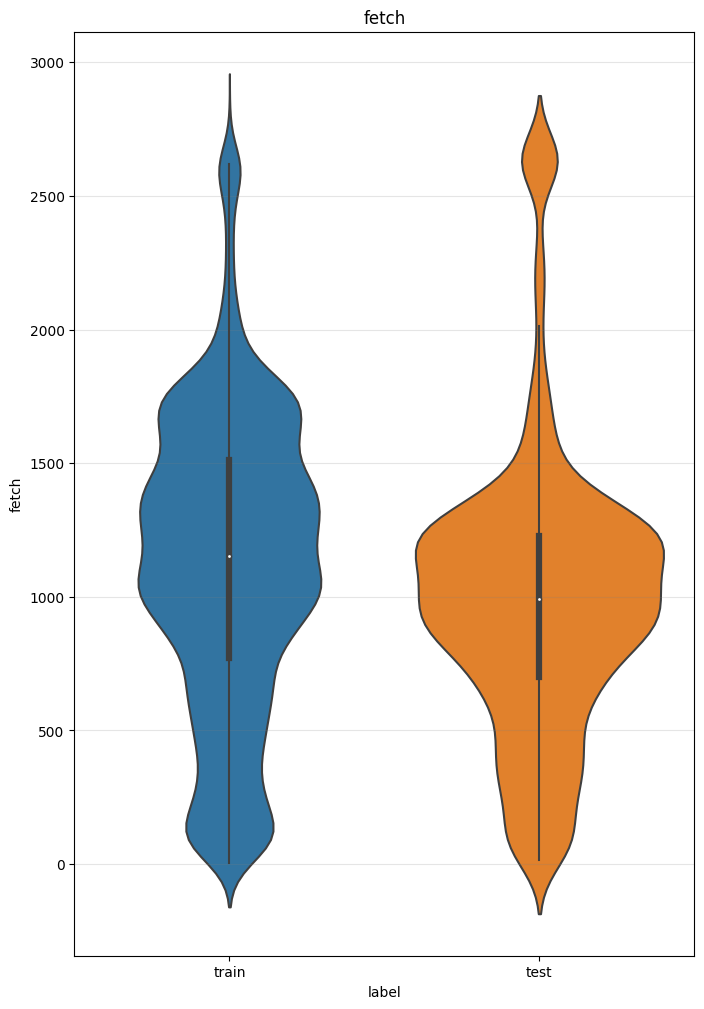

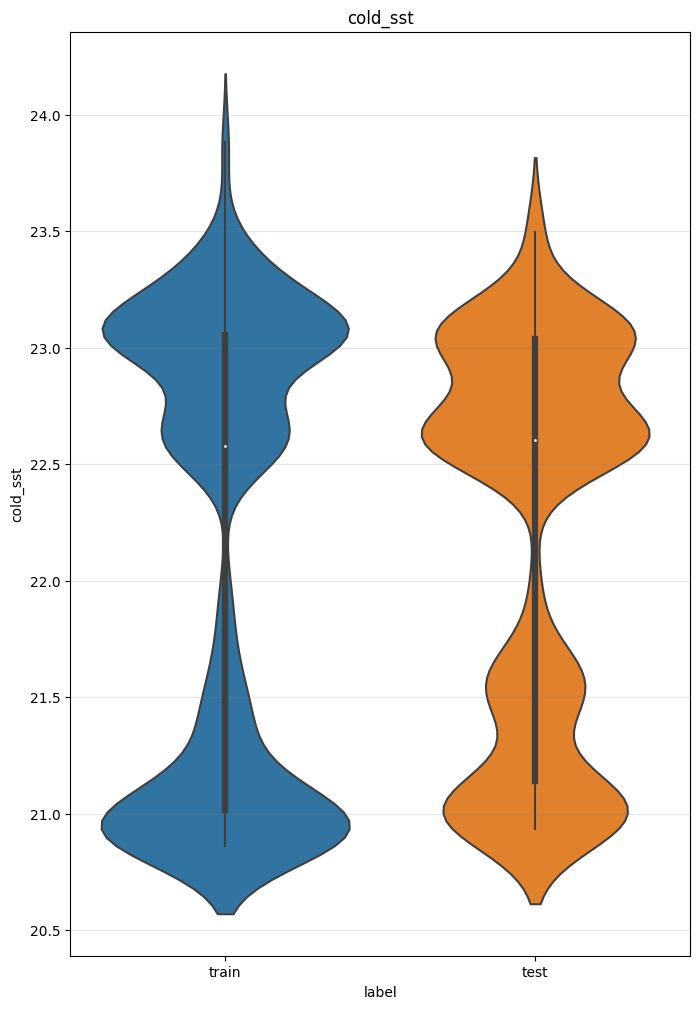

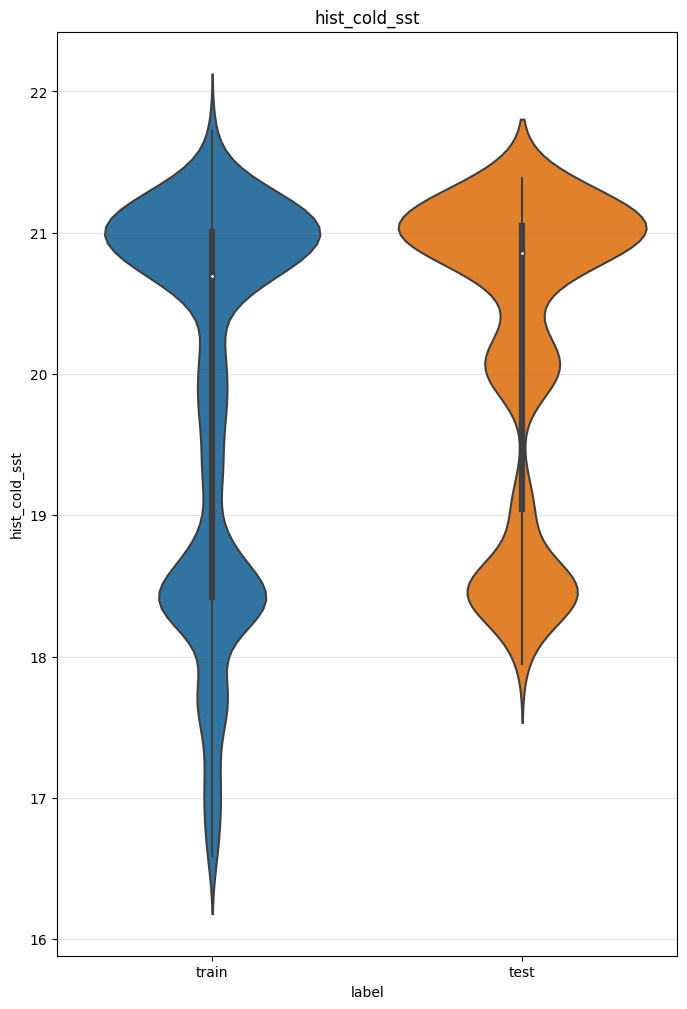

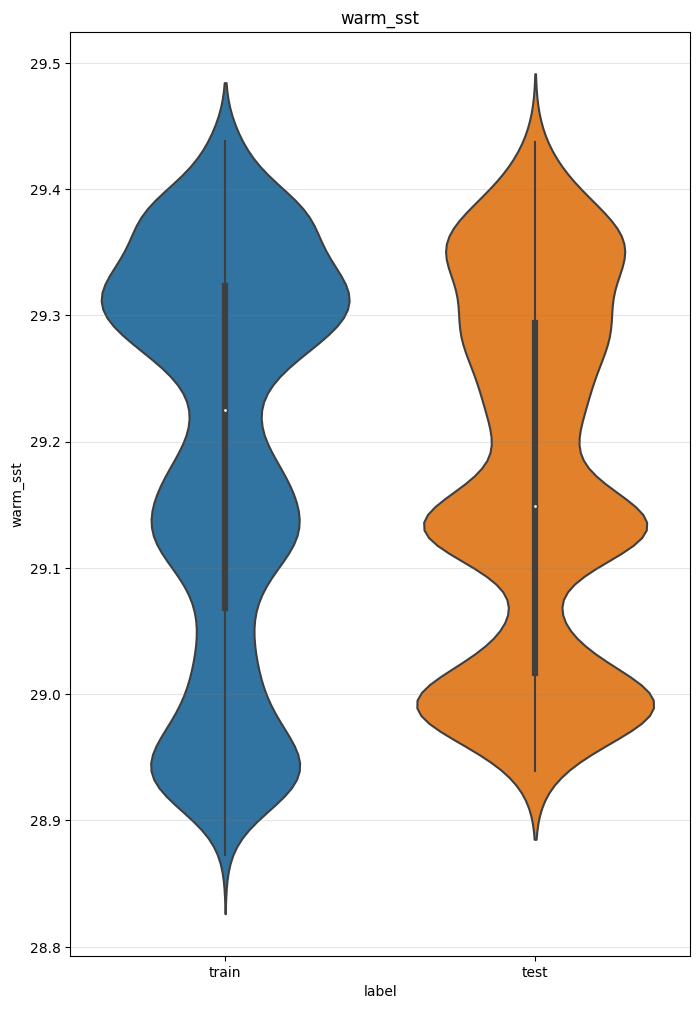

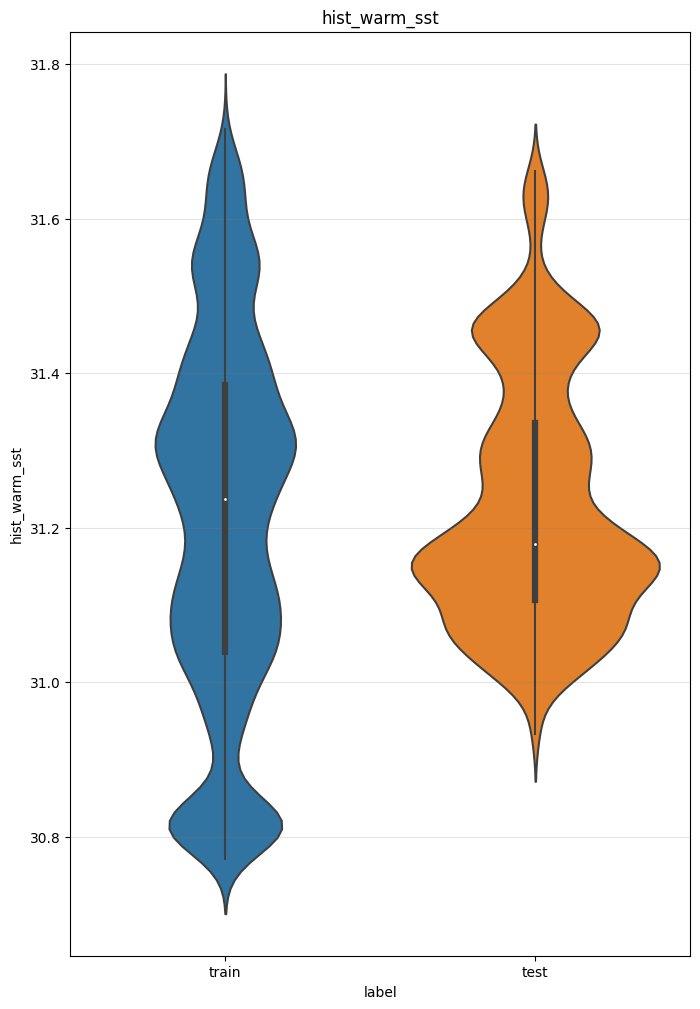

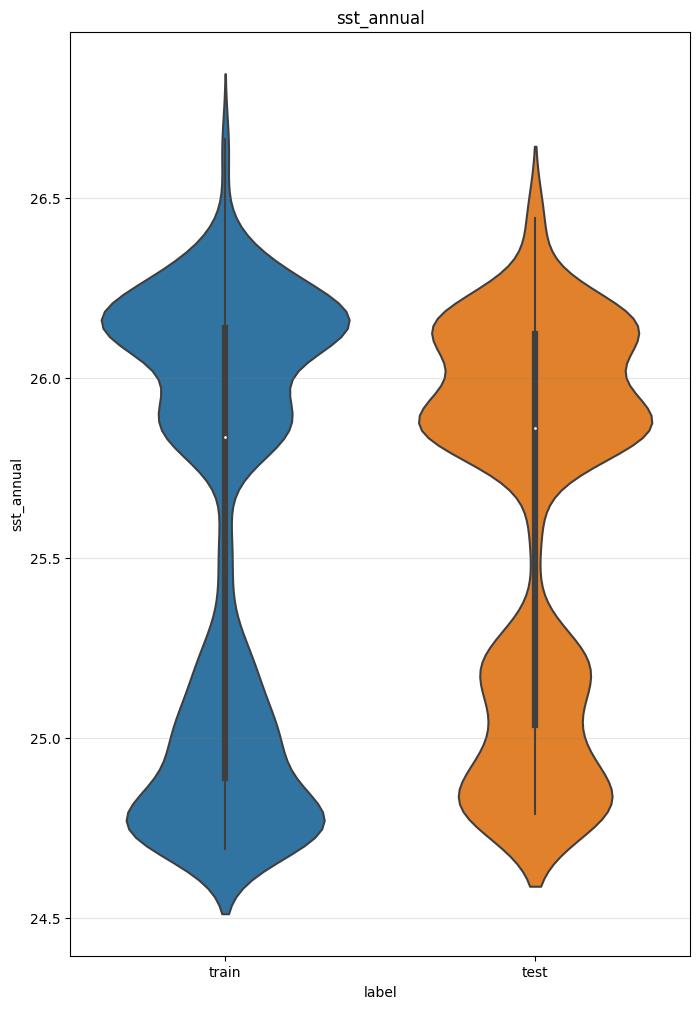

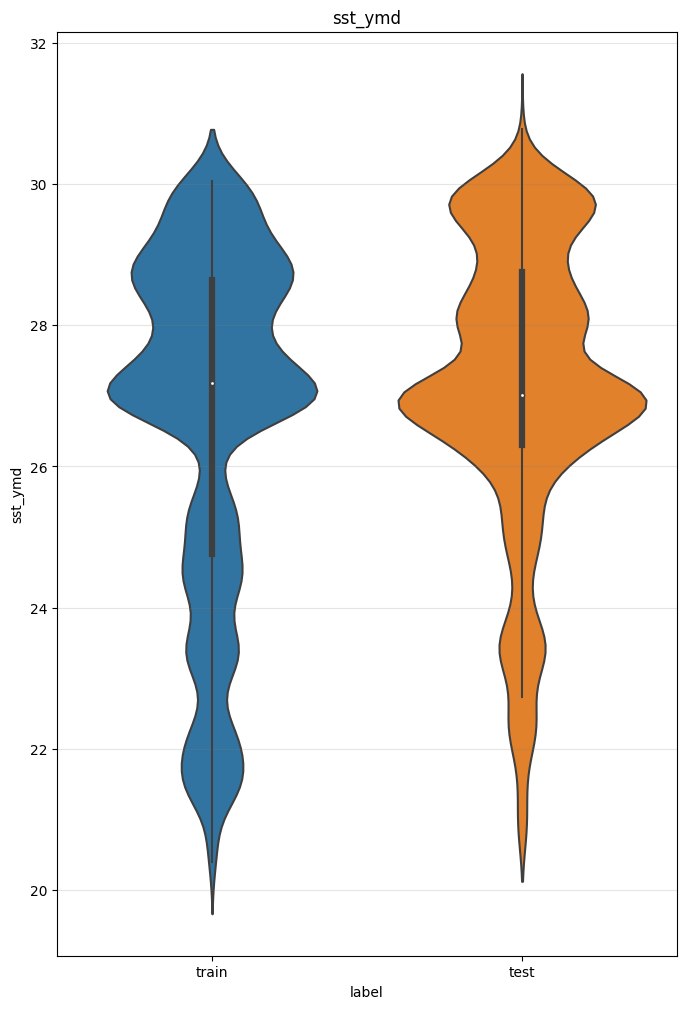

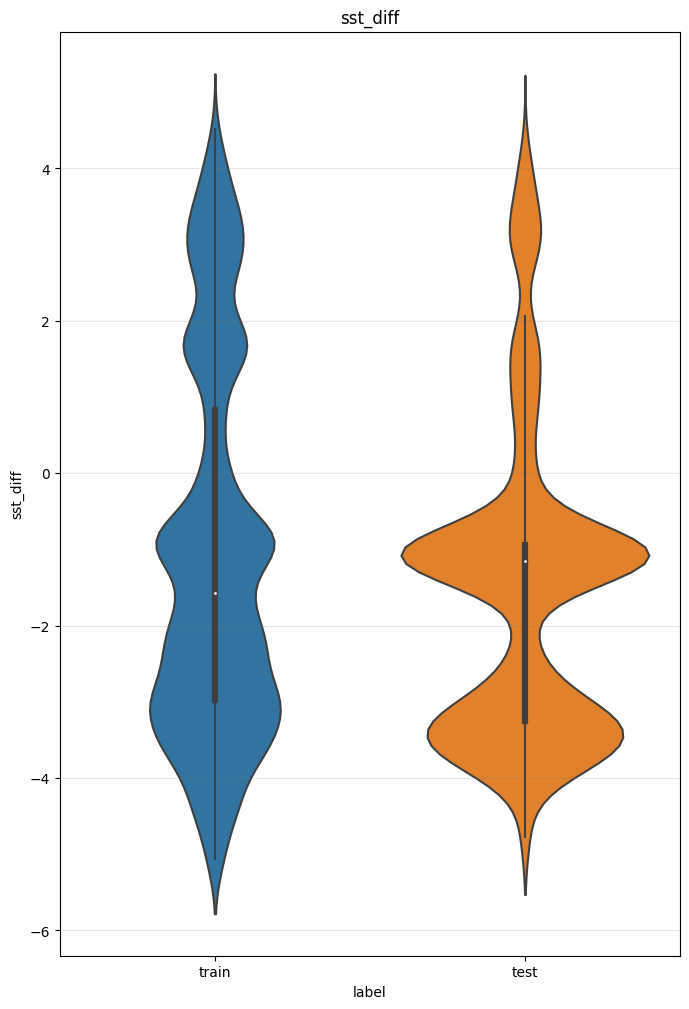

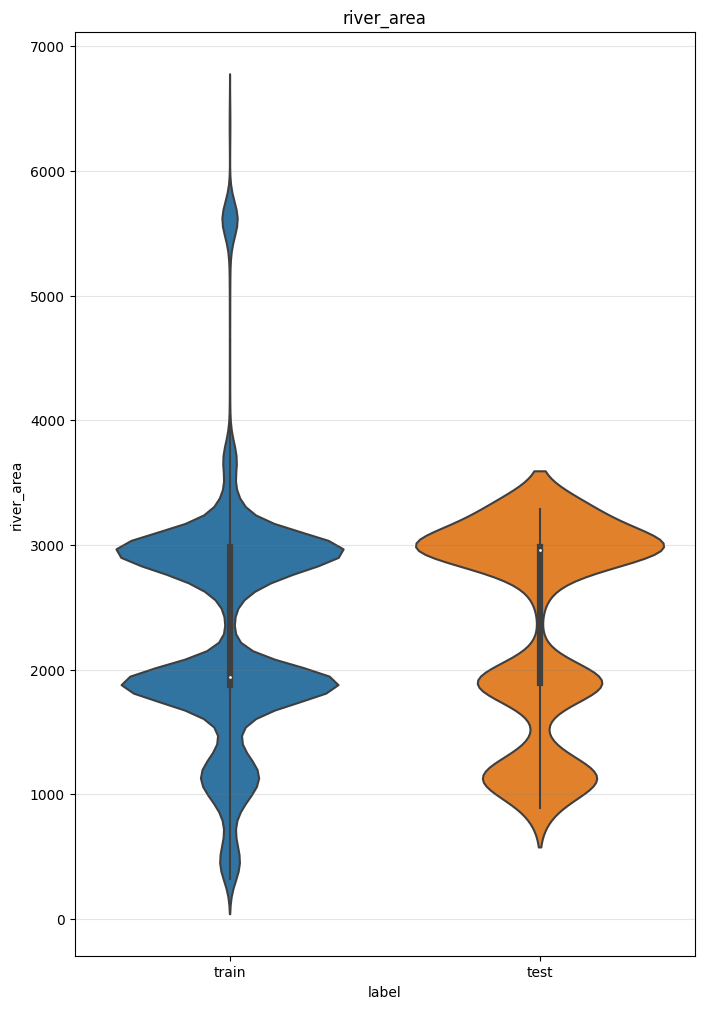

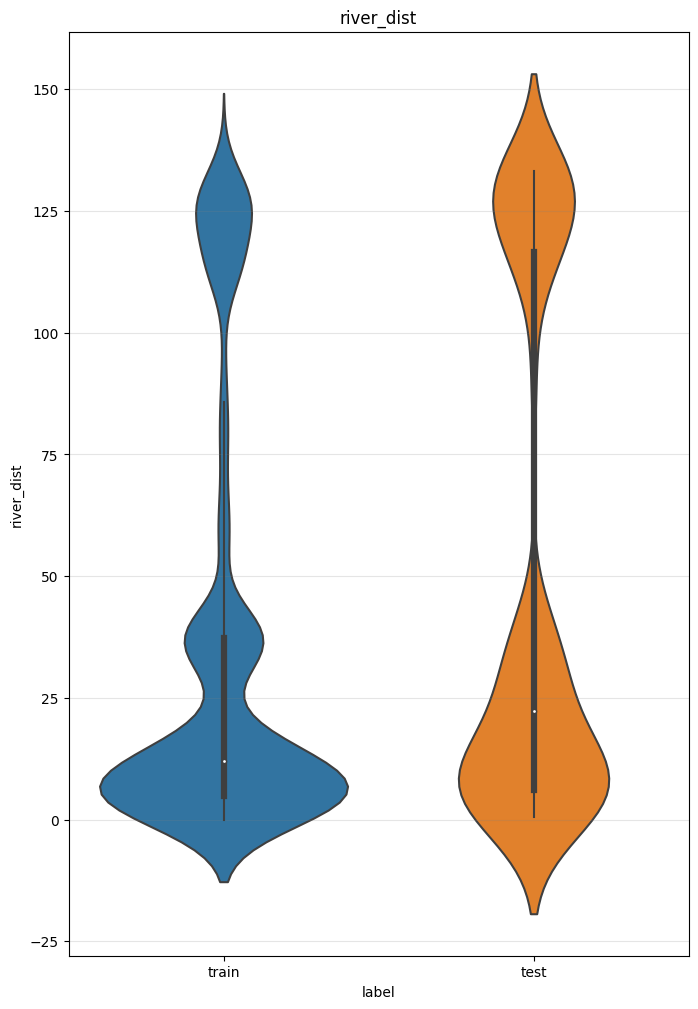

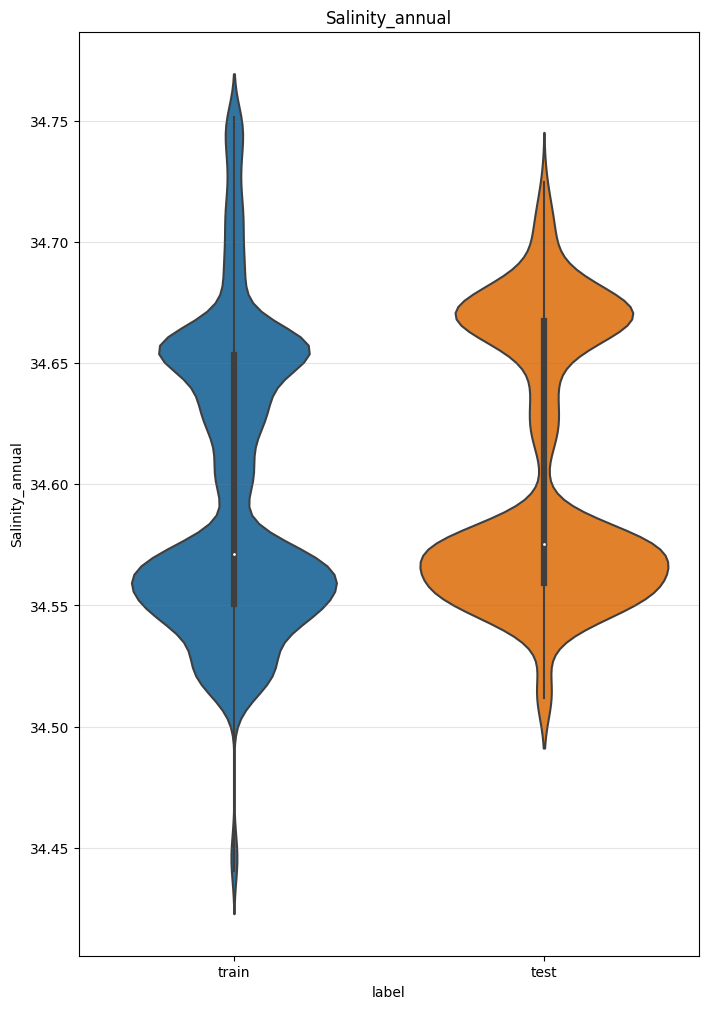

In [ ]:
for col in cols_vis:
    make_violinplot(col)

## 目的変数の分布

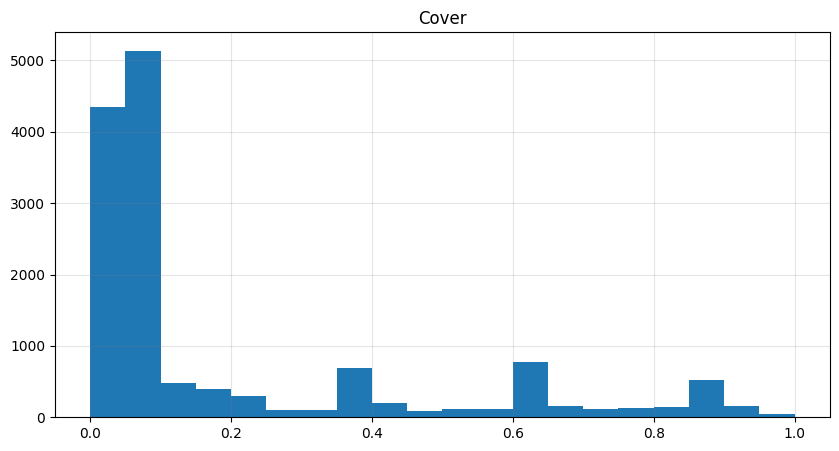

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.grid(alpha=0.2, color="gray")
ax.hist(train["cover"], bins=20)
ax.set_title("Cover")
plt.show()

## 測定位置の可視化

In [5]:
# https://signate.jp/competitions/936/discussions/20230124173017-100069
from folium import Map, Marker, Icon
from folium.plugins import MarkerCluster

In [ ]:
marker_cluster = MarkerCluster()
map = Map(location=[25.5, 127], zoom_start=10)
np_lat = train["lat"].values
np_lon = train["lon"].values

for lat, lon in zip(np_lat, np_lon):
    Marker(location=[lat, lon]).add_to(marker_cluster)

marker_cluster.add_to(map)
map.save("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219/map_ocean_train.html")

In [ ]:
marker_cluster = MarkerCluster()
map = Map(location=[25.5, 127], zoom_start=10)
np_lat = test["lat"].values
np_lon = test["lon"].values

for lat, lon in zip(np_lat, np_lon):
    Marker(location=[lat, lon]).add_to(marker_cluster)

marker_cluster.add_to(map)
map.save("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219/map_ocean_test.html")

In [ ]:
marker_cluster = MarkerCluster()
map = Map(location=[25.5, 127], zoom_start=10)
np_lat_train = train["lat"].values
np_lon_train = train["lon"].values
np_lat_test = test["lat"].values
np_lon_test = test["lon"].values

for lat, lon in zip(np_lat_train, np_lon_train):
    Marker(location=[lat, lon]).add_to(marker_cluster)
for lat, lon in zip(np_lat_test, np_lon_test):
    Marker(
        location=[lat, lon],
        icon=Icon(color="#f6aa00")
    ).add_to(marker_cluster)

marker_cluster.add_to(map)
map.save("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219/map_ocean_train_test.html")

In [9]:
#https://www.wizard-notes.com/entry/python/cmap-colorcode
list_colors = [
    "darkblue",
    "blue",
    "cabetblue",
    "green",
    "orange",
    "red",
    "darkred"
]

list_cover = [
    "0 (cover=0)",
    "1 (0<cover<0.2)",
    "2 (0.2<=cover<0.4)",
    "3 (0.4<=cover<0.6)",
    "4 (0.6<=cover<0.8)",
    "5 (0.8<=cover<1)",
    "6 (cover=1)"
]

df_location_train = train[["lat", "lon", "cover"]].dropna()
df_location_test = test[["lat", "lon"]].dropna()
df_location_train["cover_mod"] = "0 (cover=0)"
df_location_train.loc[df_location_train["cover"]>0, "cover_mod"] = "1 (0<cover<0.2)"
df_location_train.loc[df_location_train["cover"]>=0.2, "cover_mod"] = "2 (0.2<=cover<0.4)"
df_location_train.loc[df_location_train["cover"]>=0.4, "cover_mod"] = "3 (0.4<=cover<0.6)"
df_location_train.loc[df_location_train["cover"]>=0.6, "cover_mod"] = "4 (0.6<=cover<0.8)"
df_location_train.loc[df_location_train["cover"]>=0.8, "cover_mod"] = "5 (0.8<=cover<1)"
df_location_train.loc[df_location_train["cover"]>=1, "cover_mod"] = "6 (cover=1)"
df_location_train.head()

,lat,lon,cover,cover_mod
0,24.989140,125.243164,0.050,1 (0<cover<0.2)
1,26.996172,127.912025,0.725,4 (0.6<=cover<0.8)
2,26.363556,127.735138,0.025,1 (0<cover<0.2)
3,26.991255,127.912300,0.575,3 (0.4<=cover<0.6)
4,26.988255,127.917252,0.225,2 (0.2<=cover<0.4)


In [10]:
marker_cluster = MarkerCluster()
map = Map(location=[25.5, 127], zoom_start=10)

for color, cover in zip(list_colors, list_cover):
    tmp = df_location_train[df_location_train["cover_mod"]==cover]
    np_lat_train = tmp["lat"].values
    np_lon_train = tmp["lon"].values
    for lat, lon in zip(np_lat_train, np_lon_train):
        Marker(
            location=[lat, lon],
            # popup=cover,
            icon=Icon(color=color)
        ).add_to(marker_cluster)

np_lat_test = test["lat"].values
np_lon_test = test["lon"].values
for lat, lon in zip(np_lat_test, np_lon_test):
    Marker(
        location=[lat, lon],
        icon=Icon(color="gray")
    ).add_to(marker_cluster)

marker_cluster.add_to(map)
map.save("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/EDA_20230219/map_ocean_train_test_with_cover.html")

## 相関行列

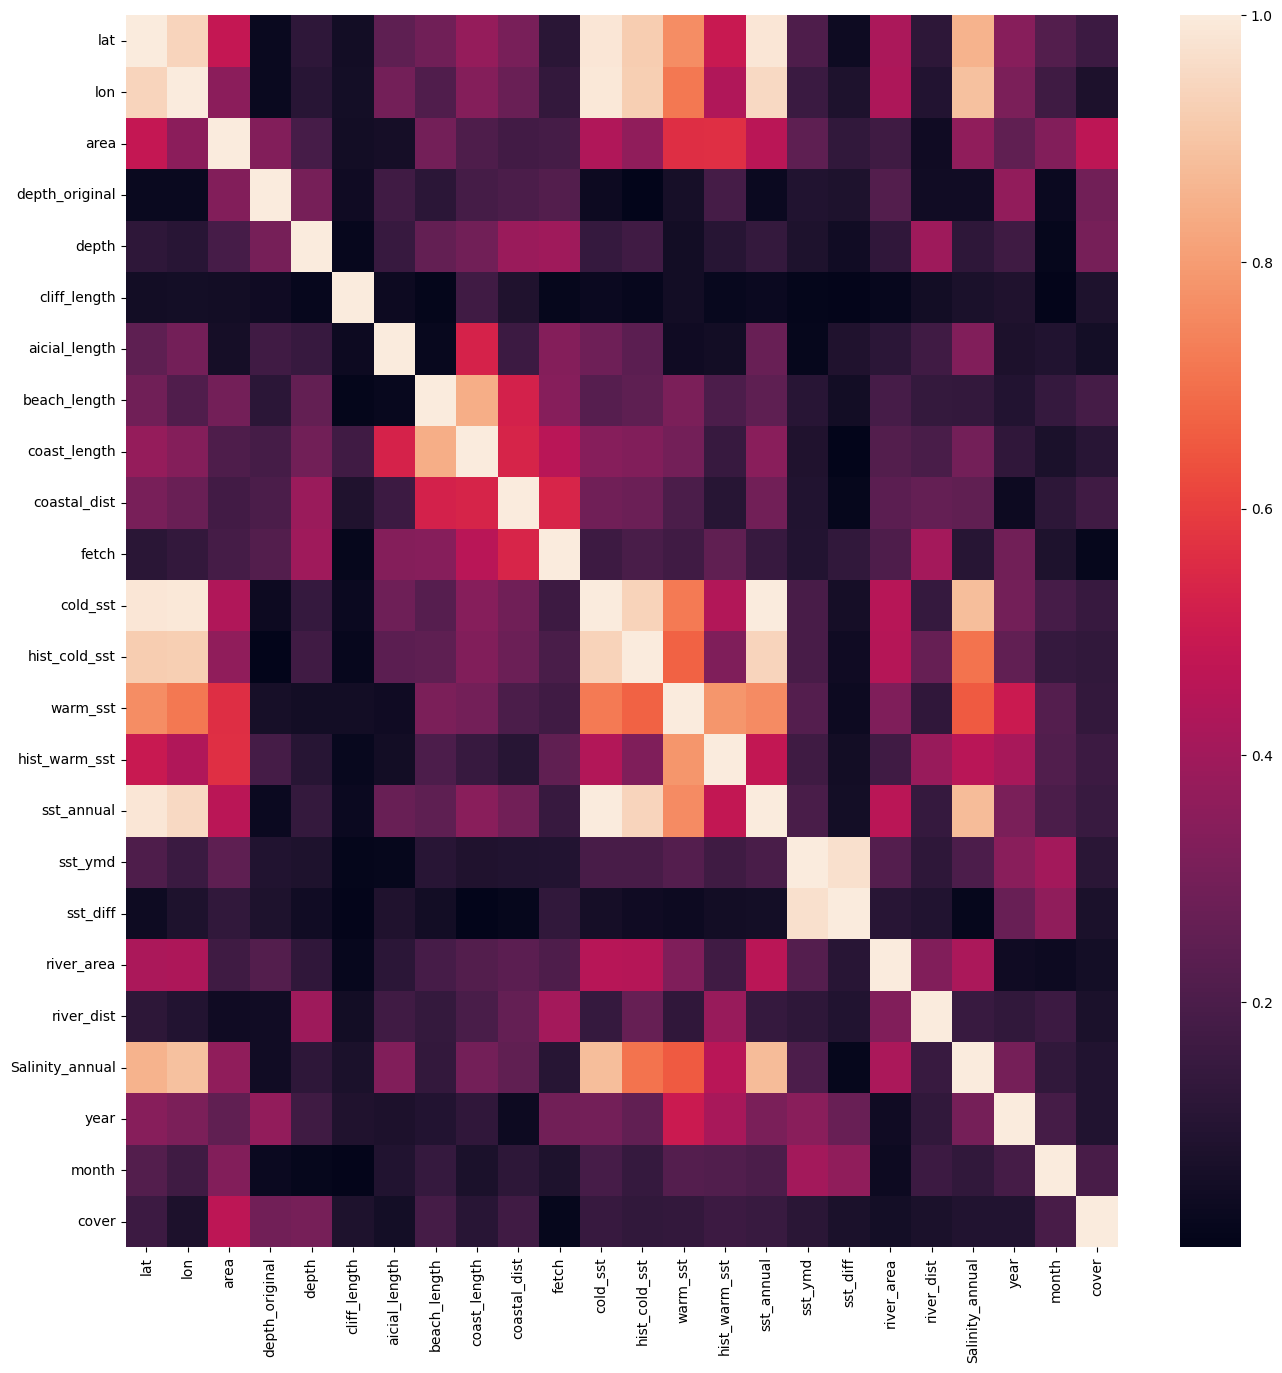

In [ ]:
cols_vis += ["year", "month", "cover", ]

df_corr = train[cols_vis].corr().abs()
fig = plt.figure(figsize=(16, 16))
sns.heatmap(df_corr);

## 行列散布図

In [ ]:
cols_pairplot1 = [
    "lat",
    "lon",
    "area",
    "year",
    "month",
    "depth_original",
    "depth",
    "cliff_length",
    "aicial_length",
    "beach_length",
    "coast_length",
    "coastal_dist",
    "cover"
]

cols_pairplot2 = [
    "fetch",
    "cold_sst",
    "hist_cold_sst",
    "warm_sst",
    "hist_warm_sst",
    "sst_annual",
    "sst_ymd",
    "sst_diff",
    "river_area",
    "river_dist",
    "Salinity_annual",
    "cover"
]

In [ ]:
fig = plt.figure(figsize=(20, 20))
sns.pairplot(train[cols_pairplot1]);

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
fig = plt.figure(figsize=(20, 20))
sns.pairplot(train[cols_pairplot2]);

Output hidden; open in https://colab.research.google.com to view.